In [2]:
import pandas as pd
import swifter
import os
import re
import subprocess
import numpy as np
from scipy import stats
import random
from jiwer import wer
import torch
from dtw import *
from scipy.spatial import distance
from datetime import date
from IPython.display import HTML, display
import collections
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import random
from collections import namedtuple

from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score
from seqeval.metrics import recall_score
from seqeval.metrics import classification_report

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertModel, AutoModelForSequenceClassification
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate
from IPython.display import HTML, display

# from match_em import analysis

import warnings
warnings.filterwarnings('ignore')

# https://huggingface.co/transformers/main_classes/logging.html
# verbosity set to print errors only, by default it is set to 30 = error and warnings
transformers.logging.set_verbosity(40)

# pd.set_option('display.max_colwidth', None)
# %matplotlib widget
tqdm.pandas()

plt.rcParams.update({'font.size': 14})

# Functions

## NLP-related

In [3]:
# GETTING POS & NER TAGS

def get_nlp_tags(df, task, nlp_pipeline):
    ref_tags = []
    asr_tags = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="NLP Tagging"):
        if (len(nlp_pipeline(row.ref_text)) == 0) & (len(nlp_pipeline(row.asr_text)) == 0):
            ref_tags.append(None)
            asr_tags.append(None)
        else:
            ref_tags.append(nlp_pipeline(row.ref_text))
            asr_tags.append(nlp_pipeline(row.asr_text))
    if task == "ner":
        df["ref_ner_tags"] = ref_tags
        df["asr_ner_tags"] = asr_tags
    elif task == "pos":
        df["ref_pos_tags"] = ref_tags
        df["asr_pos_tags"] = asr_tags
    return df



# FUNCTION FOR NER ALIGNMENT

def get_ner_alignment(df, sclite_output_dir, sclite_path, label_list):
    # combining words and tags into string of text
    ref_tokenizedtext_list = []
    asr_tokenizedtext_list = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Extracting NER tags"):
        ref_labels = []
        asr_labels = []
        for item in row.ref_ner_tags:
            word_list = item['word'].split()
            for word in word_list:
                ref_labels.append(word + "_" + label_list[int(item['entity_group'].replace("LABEL_", ""))])
        for item in row.asr_ner_tags:
            word_list = item['word'].split()
            for word in word_list:
                asr_labels.append(word + "_" + label_list[int(item['entity_group'].replace("LABEL_", ""))])
        ref_tokenizedtext_list.append(' '.join([str(elem) for elem in ref_labels]))
        asr_tokenizedtext_list.append(' '.join([str(elem) for elem in asr_labels]))

    # using sclite to find the alignment
    with open(os.path.join(sclite_output_dir, "references.txt"), "w") as f:
        for idx, utterance in enumerate(ref_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    with open(os.path.join(sclite_output_dir, "hypothesis.txt"), "w") as f:
        for idx, utterance in enumerate(asr_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    sclite_path = sclite_path
    with open(os.path.join(sclite_output_dir, 'temp_output.txt'), 'a') as outfile:
        subprocess.run([
            sclite_path,
            '-r', os.path.join(sclite_output_dir, "references.txt"),
            '-h', os.path.join(sclite_output_dir, "hypothesis.txt"),
            '-i', 'rm',
            '-o', 'all'
        ], stdout=outfile)

    # placing alignment results into the dataframe
    with open(os.path.join(sclite_output_dir, "hypothesis.txt.pra")) as f:
        lines = f.readlines()
    ref_align_list = []
    asr_align_list = []
    utt_ids_list = []
    eval_align_list = []
    for line in lines:
        clean_line = re.sub(' +', ' ', line).strip()
        text_list = clean_line.split(" ")
        # text_list = [item.lower() for item in text_list]
        if text_list[0] == "id:":
            utt_ids_list.append(text_list[1])
        elif text_list[0] == "REF:":
            ref_align_list.append(text_list[1:])
        elif text_list[0] == "HYP:":
            asr_align_list.append(text_list[1:])
    df["ref_token"] = ref_align_list
    df["asr_token"] = asr_align_list
    eval_align_list = []
    for row in df.itertuples():
        eval_token_list = []
        ref_token_list = row.ref_token
        asr_token_list = row.asr_token
        for idx, ref_token in enumerate(ref_token_list):
            if ref_token == asr_token_list[idx]:
                eval_token_list.append("m")
            elif "*" in ref_token:
                eval_token_list.append("I")
            elif "*" in asr_token_list[idx]:
                eval_token_list.append("D")
            elif ref_token != asr_token_list[idx]:
                eval_token_list.append("S")
        eval_align_list.append(eval_token_list)
    df["eval_token"] = eval_align_list

    # cleanup dataframe by removing items with no NER tags at all
    idx_to_drop = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Remove no NER tags"):
        if (len(row.ref_ner_tags) == 1) & (row.ref_ner_tags[0]["entity_group"] == "LABEL_0"):
            idx_to_drop.append(idx)
    df.drop(idx_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # getting aligned ASR and REF labels (individually, word-wise)
    ref_labels = []
    asr_labels = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Aligning REF & ASR labels"):
        ref_tags = []
        for item in row.ref_token:
            tokens = item.split("_")
            if len(tokens) == 1:
                ref_tags.append("O")
            elif len(tokens) == 2:
                ref_tags.append(tokens[1].upper())
            elif len(tokens) == 3:
                ref_tags.append(tokens[1].upper() + "_" + tokens[2].upper())
        ref_labels.append(ref_tags)
        asr_tags = []
        for item in row.asr_token:
            tokens = item.split("_")
            if len(tokens) == 1:
                asr_tags.append("O")
            elif len(tokens) == 2:
                asr_tags.append(tokens[1].upper())
            elif len(tokens) == 3:
                asr_tags.append(tokens[1].upper() + "_" + tokens[2].upper())
        asr_labels.append(asr_tags)
    df["ref_labels"] = ref_labels
    df["asr_labels"] = asr_labels

    print("get alignment - DONE")

    return df, idx_to_drop



# FUNCTIONS FOR SENTIMENT ANALYSIS

def get_pred_label(x):
    if x == 0:
        return ['Neutral']
    elif x == 1:
        return ['Positive']
    else:
        return ['Negative']

def get_sentiment(df, model, tokenizer):
    asr_sentiment = []
    ref_sentiment = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Sentiment tagging"):
        tokenized_ref = tokenizer(row.ref_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokenized_asr = tokenizer(row.asr_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            model_output_ref = model(**tokenized_ref, output_hidden_states=False)
            model_output_asr = model(**tokenized_asr, output_hidden_states=False)
        pred_ref = model_output_ref['logits'].numpy()
        ref_sentiment.append(np.argmax(pred_ref, axis=1))
        pred_asr = model_output_asr['logits'].numpy()
        asr_sentiment.append(np.argmax(pred_asr, axis=1))
    df['ref_sentiment'] = ref_sentiment
    df['asr_sentiment'] = asr_sentiment
    df['ref_sentiment'] = df['ref_sentiment'].map(get_pred_label)
    df['asr_sentiment'] = df['asr_sentiment'].map(get_pred_label)
    return df

def get_sentiment_tag(text, model, tokenizer):
    tokenized_text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**tokenized_text, output_hidden_states=False)
    prediction = np.argmax((model_output['logits'].numpy()), axis=1)
    if prediction == 0:
        return ['Neutral']
    elif prediction == 1:
        return ['Positive']
    else:
        return ['Negative']



# FUNCTIONS FOR MODIFYING THE TRANSCRIPTIONS

def get_worse_asd_ner(df, dummy_word):
    df.drop(["asr_text", "wer", "asd"], axis="columns", inplace=True)
    mod_asr_text = []
    # replaced_words = []
    # replaced_entities = []
    # label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-GPE_LOC', 'I-GPE_LOC', 'B-PROD', 'I-PROD', 'B-LOC', 'I-LOC', 'B-GPE_ORG', 'I-GPE_ORG', 'B-DRV', 'I-DRV', 'B-EVT', 'I-EVT', 'B-MISC', 'I-MISC']
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Mod Worse ASD"):
        word_list = row.ref_text.split()
        total_error = int(row.total_error)
        if len(word_list) >= total_error:
            for idx, word in enumerate(word_list):
                if total_error > 0:
                    if nlp_ner(word)[0]["entity_group"] != "LABEL_0":
                        # replaced_words.append(word)
                        # replaced_entities.append(label_list[int(nlp_ner(word)[0]['entity_group'].replace("LABEL_", ""))])
                        word_list[idx] = dummy_word
                        total_error -= 1
            for i in range(0, total_error):
                random_idx = random.sample(range(0, len(word_list)), 1)
                while word_list[random_idx[0]] == dummy_word:
                    random_idx = random.sample(range(0, len(word_list)), 1)
                # replaced_words.append(word_list[random_idx[0]])
                # replaced_entities.append(label_list[int(nlp_ner(word_list[random_idx[0]])[0]['entity_group'].replace("LABEL_", ""))])
                word_list[random_idx[0]] = dummy_word
            # random_idx = random.sample(range(0, len(word_list)), int(row.total_error))
            # for idx in random_idx:
            #     word_list[idx] = ''.join(random.sample(word_list[idx], len(word_list[idx])))
            mod_asr_text.append(" ".join(word_list))
        else:
            excess_errors = int(row.total_error) - len(word_list)
            for idx, __ in enumerate(word_list):
                word_list[idx] = dummy_word
            for i in range(0, excess_errors):
                word_list.append(dummy_word)
            mod_asr_text.append(" ".join(word_list))
    df["asr_text"] = mod_asr_text
    return df

def get_worse_asd(df, dummy_word):
    df.drop(["asr_text", "wer", "asd"], axis="columns", inplace=True)
    mod_asr_text = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Mod Worse ASD"):
        word_list = row.ref_text.split()
        total_error = int(row.total_error)
        if len(word_list) >= total_error:
            # random_idx = random.sample(range(0, len(word_list)), total_error)
            # for idx in random_idx:
            #     word_list[idx] = dummy_word
            for i in range(0, total_error):
                random_idx = random.sample(range(0, len(word_list)), 1)
                while word_list[random_idx[0]] == dummy_word:
                    random_idx = random.sample(range(0, len(word_list)), 1)
                word_list[random_idx[0]] = dummy_word
            mod_asr_text.append(" ".join(word_list))
        else:
            excess_errors = int(row.total_error) - len(word_list)
            for idx, __ in enumerate(word_list):
                word_list[idx] = dummy_word
            for i in range(0, excess_errors):
                word_list.append(dummy_word)
            mod_asr_text.append(" ".join(word_list))
    df["asr_text"] = mod_asr_text
    return df

def get_better_asd(df, dummy_word):
    df.drop(["asr_text", "wer", "asd"], axis="columns", inplace=True)
    mod_asr_text = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Mod Better ASD"):
        word_list = row.ref_text.split()
        if len(word_list) >= int(row.total_error):
            if row.total_error == 1:
                word_list.append(dummy_word)
            else:
                for i in range(0, int(row.total_error)):
                    random_idx = random.sample(range(0, len(word_list)), 1)
                    word_list.insert(random_idx[0], dummy_word)
            mod_asr_text.append(" ".join(word_list))
        else:
            excess_errors = int(row.total_error) - len(word_list)
            for idx, __ in enumerate(word_list):
                word_list[idx] = dummy_word
            for i in range(0, excess_errors):
                word_list.append(dummy_word)
            mod_asr_text.append(" ".join(word_list))
    df["asr_text"] = mod_asr_text
    return df


In [4]:
# FUNCTIONS FOR POS EXPERIMENT

def get_pos_alignment(df, sclite_output_dir, sclite_path, label_list):
    ref_tokenizedtext_list = []
    asr_tokenizedtext_list = []
    ref_nlp_labels = []
    asr_nlp_labels = []
    for row in df.itertuples():
        ref_labels = []
        ref_labels_int = []
        asr_labels = []
        asr_labels_int = []
        for item in row.ref_pos_tags:
            ref_labels.append(item['word'] + "_" + label_list[int(item['entity'].replace("LABEL_", ""))])
            ref_labels_int.append(int(item['entity'].replace("LABEL_", "")))
        for item in row.asr_pos_tags:
            asr_labels.append(item['word'] + "_" + label_list[int(item['entity'].replace("LABEL_", ""))])
            asr_labels_int.append(int(item['entity'].replace("LABEL_", "")))
        ref_tokenizedtext_list.append(' '.join([str(elem) for elem in ref_labels]))
        asr_tokenizedtext_list.append(' '.join([str(elem) for elem in asr_labels]))
        ref_nlp_labels.append(ref_labels_int)
        asr_nlp_labels.append(asr_labels_int)

    df["ref_labels"] = ref_nlp_labels
    df["asr_labels"] = asr_nlp_labels

    with open(os.path.join(sclite_output_dir, "references.txt"), "w") as f:
        for idx, utterance in enumerate(ref_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    with open(os.path.join(sclite_output_dir, "hypothesis.txt"), "w") as f:
        for idx, utterance in enumerate(asr_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    sclite_path = sclite_path
    with open(os.path.join(sclite_output_dir, 'temp_output.txt'), 'a') as outfile:
        subprocess.run([
            sclite_path,
            '-r', os.path.join(sclite_output_dir, "references.txt"),
            '-h', os.path.join(sclite_output_dir, "hypothesis.txt"),
            '-i', 'rm',
            '-o', 'all'
        ], stdout=outfile)

    with open(os.path.join(sclite_output_dir, "hypothesis.txt.pra")) as f:
        lines = f.readlines()
    ref_align_list = []
    asr_align_list = []
    utt_ids_list = []
    eval_align_list = []
    for line in lines:
        clean_line = re.sub(' +', ' ', line).strip()
        text_list = clean_line.split(" ")
        # text_list = [item.lower() for item in text_list]
        if text_list[0] == "id:":
            utt_ids_list.append(text_list[1])
        elif text_list[0] == "REF:":
            ref_align_list.append(text_list[1:])
        elif text_list[0] == "HYP:":
            asr_align_list.append(text_list[1:])
    df["ref_token"] = ref_align_list
    df["asr_token"] = asr_align_list
    eval_align_list = []
    for row in df.itertuples():
        eval_token_list = []
        ref_token_list = row.ref_token
        asr_token_list = row.asr_token
        for idx, ref_token in enumerate(ref_token_list):
            if ref_token == asr_token_list[idx]:
                eval_token_list.append("m")
            elif "*" in ref_token:
                eval_token_list.append("I")
            elif "*" in asr_token_list[idx]:
                eval_token_list.append("D")
            elif ref_token != asr_token_list[idx]:
                eval_token_list.append("S")
        eval_align_list.append(eval_token_list)
    df["eval_token"] = eval_align_list

    print("get alignment - DONE")

    return df



def get_pos_eval_dict(df):
    eval_tag_dict = []
    for row in df.itertuples():
        eval_list = []
        for idx, item in enumerate(row.eval_token):
            if item == "D":
                eval_list.append({"error":"deletion",
                                  "token_ref":row.ref_token[idx].split("_")[0],
                                  "tag_ref":row.ref_token[idx].split("_")[1],
                                  "index":idx
                                 })
            elif item == "S":
                eval_list.append({"error":"substitution",
                                  "token_ref":row.ref_token[idx].split("_")[0],
                                  "tag_ref":row.ref_token[idx].split("_")[1],
                                  "token_asr":row.asr_token[idx].split("_")[0],
                                  "tag_asr":row.asr_token[idx].split("_")[1],
                                  "index":idx
                                 })
            elif item == "I":
                eval_list.append({"error":"insertion",
                                  "token_asr":row.asr_token[idx].split("_")[0],
                                  "tag_asr":row.asr_token[idx].split("_")[1],
                                  "index":idx
                                 })
        eval_tag_dict.append(eval_list)
    df["eval_tag_dict"] = eval_tag_dict
    df = tul_asr_df_pos_cleanup.drop(["eval_token"], axis="columns")
    return df



def get_pos_error_vectors(df, label_list):
    error_counts = []
    ref_vectors = []
    asr_vectors = []

    for row in df.itertuples():
        ref_vector = np.zeros(len(label_list), dtype=int)
        asr_vector = np.zeros(len(label_list), dtype=int)

        for item in row.ref_token:
            if "*" in item:
                continue
            else:
                err_type = item.split("_")[1].upper()
                ref_vector[label_list.index(err_type)] += 1
        ref_vectors.append(ref_vector)

        for item in row.asr_token:
            if "*" in item:
                continue
            else:
                err_type = item.split("_")[1].upper()
                asr_vector[label_list.index(err_type)] += 1
        asr_vectors.append(asr_vector)

        if len(ref_vector) == len(asr_vector):
            diff_vector = np.zeros(len(ref_vector), dtype=int)
            for idx, refcount in enumerate(ref_vector):
                diff_vector[idx] += abs(refcount - asr_vector[idx])
        error_counts.append(diff_vector)

    df["ref_vector"] = ref_vectors
    df["asr_vector"] = asr_vectors
    df["error_counts"] = error_counts

    return df


## Getting ASD score

In [5]:
def get_asd_score(ref, hyp, model, tokenizer):
    tokenized_ref = tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        model_output_ref = model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = [hidden_states_ref[1].squeeze(), hidden_states_ref[2].squeeze(), hidden_states_ref[3].squeeze(), hidden_states_ref[4].squeeze(),
                            hidden_states_ref[5].squeeze(), hidden_states_ref[6].squeeze(), hidden_states_ref[7].squeeze(), hidden_states_ref[8].squeeze(),
                            hidden_states_ref[9].squeeze(), hidden_states_ref[10].squeeze(), hidden_states_ref[11].squeeze(), hidden_states_ref[12].squeeze()]
    all_layers_hypothesis = [hidden_states_hyp[1].squeeze(), hidden_states_hyp[2].squeeze(), hidden_states_hyp[3].squeeze(), hidden_states_hyp[4].squeeze(),
                             hidden_states_hyp[5].squeeze(), hidden_states_hyp[6].squeeze(), hidden_states_hyp[7].squeeze(), hidden_states_hyp[8].squeeze(),
                             hidden_states_hyp[9].squeeze(), hidden_states_hyp[10].squeeze(), hidden_states_hyp[11].squeeze(), hidden_states_hyp[12].squeeze()]
    output_mean_reference = torch.stack(all_layers_reference).mean(dim=0)
    output_mean_hypothesis = torch.stack(all_layers_hypothesis).mean(dim=0)
    alignment = dtw(output_mean_hypothesis, output_mean_reference, dist_method=distance.cosine, keep_internals=True)
    num_tokens = len(output_mean_reference)
    min_global_distance_norm = (alignment.distance / num_tokens)
    return min_global_distance_norm


def get_asd_score_modlayers(ref, hyp, model, tokenizer, layer_nos):
    tokenized_ref = tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        model_output_ref = model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    layers_reference = []
    layers_hypothesis = []
    for num in layer_nos:
        layers_reference.append(hidden_states_ref[num].squeeze())
        layers_hypothesis.append(hidden_states_hyp[num].squeeze())
    output_mean_reference = torch.stack(layers_reference).mean(dim=0)
    output_mean_hypothesis = torch.stack(layers_hypothesis).mean(dim=0)
    alignment = dtw(output_mean_hypothesis, output_mean_reference, dist_method=distance.cosine, keep_internals=True)
    num_tokens = len(output_mean_reference)
    min_global_distance_norm = (alignment.distance / num_tokens)
    return min_global_distance_norm


# FOR VISUAL INSPECTION OF ALIGNMENTS

def get_asd_alignment(tokenized_ref, tokenized_hyp, model):
    with torch.no_grad():
        model_output_ref = model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = [hidden_states_ref[1].squeeze(), hidden_states_ref[2].squeeze(), hidden_states_ref[3].squeeze(), hidden_states_ref[4].squeeze(),
                            hidden_states_ref[5].squeeze(), hidden_states_ref[6].squeeze(), hidden_states_ref[7].squeeze(), hidden_states_ref[8].squeeze(),
                            hidden_states_ref[9].squeeze(), hidden_states_ref[10].squeeze(), hidden_states_ref[11].squeeze(), hidden_states_ref[12].squeeze()]
    all_layers_hypothesis = [hidden_states_hyp[1].squeeze(), hidden_states_hyp[2].squeeze(), hidden_states_hyp[3].squeeze(), hidden_states_hyp[4].squeeze(),
                             hidden_states_hyp[5].squeeze(), hidden_states_hyp[6].squeeze(), hidden_states_hyp[7].squeeze(), hidden_states_hyp[8].squeeze(),
                             hidden_states_hyp[9].squeeze(), hidden_states_hyp[10].squeeze(), hidden_states_hyp[11].squeeze(), hidden_states_hyp[12].squeeze()]
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)
    alignment = dtw(x=hyp_embedding_sequence, y=ref_embedding_sequence, dist_method="cosine", keep_internals=True)
    num_tokens = len(ref_embedding_sequence)
    asd_score = (alignment.distance / num_tokens)
    return alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score


def print_token_alignment(tokenizer, alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids):
    hyp_alignment_idxs = alignment.index1
    ref_alignment_idxs = alignment.index2

    hyp_alignment_input_ids = np.empty(len(hyp_alignment_idxs), dtype=int)
    for i, index in enumerate(hyp_alignment_idxs):
        hyp_alignment_input_ids[i] = (hyp_input_ids[index])
    hyp_alignment_input_ids_tensor = torch.from_numpy(hyp_alignment_input_ids)

    ref_alignment_input_ids = np.empty(len(ref_alignment_idxs), dtype=int)
    for i, index in enumerate(ref_alignment_idxs):
        ref_alignment_input_ids[i] = (ref_input_ids[index])
    ref_alignment_inpud_ids_tensor = torch.from_numpy(ref_alignment_input_ids)

    hyp_alignment_tokens = tokenizer.convert_ids_to_tokens(hyp_alignment_input_ids_tensor)
    ref_alignment_tokens = tokenizer.convert_ids_to_tokens(ref_alignment_inpud_ids_tensor)

    ref_alignment_token_embeddings = []
    for index in ref_alignment_idxs:
        ref_alignment_token_embeddings.append(ref_embedding_sequence[index])

    hyp_alignment_token_embeddings = []
    for index in hyp_alignment_idxs:
        hyp_alignment_token_embeddings.append(hyp_embedding_sequence[index])

    cosdist_alignment_tokens = []
    for i in range(len(ref_alignment_token_embeddings)):
        ref_embedding = ref_alignment_token_embeddings[i]
        hyp_embedding = hyp_alignment_token_embeddings[i]
        cosdist_alignment_tokens.append(round((distance.cosine(ref_embedding, hyp_embedding)), 3))
    hyp_alignment_tokens.insert(0, "HYP:")
    ref_alignment_tokens.insert(0, "REF:")
    cosdist_alignment_tokens.insert(0, "CosDist:")
    alignment_table = [ref_alignment_tokens, hyp_alignment_tokens, cosdist_alignment_tokens]
    table = tabulate(alignment_table, tablefmt="html")

    print("Token alignment table:")
    display(HTML(table))

    # print("ASD score from alignment:", total_dist/len(ref_alignment_token_embeddings))


----
## ASD Model Initialization

In [6]:
# https://huggingface.co/transformers/main_classes/logging.html
# verbosity set to print errors only, by default it is set to 30 = error and warnings
transformers.logging.set_verbosity(40)

# The bare Bert Model transformer outputting raw hidden-states without any specific head on top.
modelname = 'ltgoslo/norbert'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

modelname = "bert-base-multilingual-cased"
asd_multi_model = BertModel.from_pretrained(modelname)
asd_multi_tokenizer = AutoTokenizer.from_pretrained(modelname)

# updated NorBERT models
modelname = 'ltg/norbert'
asd_model_norbert = BertModel.from_pretrained(modelname)
asd_tokenizer_norbert = AutoTokenizer.from_pretrained(modelname)

modelname = 'ltg/norbert2'
asd_model_norbert2 = BertModel.from_pretrained(modelname)
asd_tokenizer_norbert2 = AutoTokenizer.from_pretrained(modelname)

Downloading: 100%|██████████| 382/382 [00:00<00:00, 354kB/s]
Downloading: 100%|██████████| 448M/448M [00:08<00:00, 55.4MB/s] 
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 32.8kB/s]
Downloading: 100%|██████████| 261k/261k [00:00<00:00, 4.80MB/s]
Downloading: 100%|██████████| 4.00/4.00 [00:00<00:00, 5.74kB/s]
Downloading: 100%|██████████| 382/382 [00:00<00:00, 449kB/s]
Downloading: 100%|██████████| 448M/448M [00:04<00:00, 99.2MB/s] 
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 34.8kB/s]
Downloading: 100%|██████████| 261k/261k [00:00<00:00, 1.44MB/s]
Downloading: 100%|██████████| 4.00/4.00 [00:00<00:00, 4.18kB/s]
Downloading: 100%|██████████| 113/113 [00:00<00:00, 151kB/s]


---
# Segmenting E2E TUL ASR Results (2022)

## Data Preparation

In [4]:
# # listing sources for extraction of dataframes

# path = './E2E_ASR_results_from_TUL/TUL_ASR_ver1_segmented'
# dir_list = os.listdir(path)

# source_list = []
# for item in dir_list:
#     if os.path.splitext(item)[1] == '.csv':
#         source_list.append(os.path.splitext(item)[0])

# rundkast_sources = source_list[:3]
# nbtale_sources = source_list[3:]

In [5]:
# # exporting individual dataframes for NB Tale

# df_e2e_nbtale = pd.read_csv('./E2E_ASR_results_from_TUL/df_e2e_nbtale.csv')
# df_e2e_nbtale = df_e2e_nbtale.drop(['Unnamed: 0', 'time', 'result_fn'], axis='columns')

# def get_df_section(df, source):
#     return  df[df['audio_source'] == source]

# export_path = './E2E_ASR_results_from_TUL/'
# # for source in nbtale_sources:
# #     get_df_section(df_e2e_nbtale, source).to_csv(export_path + 'df_e2e_nbtale_' + source + '.csv')

In [6]:
# # exporting individual dataframes for Rundkast

# df_e2e_rundkast = pd.read_csv('./E2E_ASR_results_from_TUL/df_e2e_rundkast.csv')
# df_e2e_rundkast = df_e2e_rundkast.drop(['Unnamed: 0', 'time', 'result_fn'], axis='columns')

# def get_df_section(df, source):
#     return  df[df['audio_source'] == source]

# export_path = './E2E_ASR_results_from_TUL/'
# # for source in rundkast_sources:
# #     get_df_section(df_e2e_rundkast, source).to_csv(export_path + 'df_e2e_rundkast_' + source + '.csv')

## Sentence Extraction & Metric Calculation

In [7]:
# export_path = './E2E_ASR_results_from_TUL/e2e_segmented/'

In [8]:
# # NB TALE

# file_dir = "./E2E_ASR_results_from_TUL/segment_bounds/nb_tale"

# path_list = []
# for file in os.listdir(file_dir):
#     if file.endswith(".csv"):
#         path_list.append(os.path.join(file_dir, file))

# frames = []
# for path in path_list:
#     df = pd.read_csv(path)
#     df["total_error"] = df["eval"].apply(lambda x: 1 if(x != "match") else 0)
#     df_ref = df[["ref_text", "segments"]].dropna(subset=["ref_text"]).groupby("segments")["ref_text"].apply(lambda x: " ".join(x))
#     df_asr = df[["asr_text", "segments"]].dropna(subset=["asr_text"]).groupby("segments")["asr_text"].apply(lambda x: " ".join(x))
#     df_err = df[["total_error", "segments"]].groupby("segments")["total_error"].apply(lambda x: sum(x))
#     df_seg = pd.merge(df_ref, df_asr, left_index=True, right_index=True)
#     df_seg = pd.merge(df_seg, df_err, left_index=True, right_index=True)
#     df_seg.fillna(0, inplace=True)
#     df_seg.reset_index(inplace=True)
#     df_seg["wer"] = df_seg[["ref_text", "asr_text"]].swifter.apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
#     df_seg["asd"] = df_seg[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)
#     frames.append(df_seg)

# df_e2e_nbtale_seg = pd.concat(frames)
# df_e2e_nbtale_seg.reset_index(drop=True, inplace=True)
# df_e2e_nbtale_seg.drop(["segments"], axis="columns", inplace=True)
# df_e2e_nbtale_seg["source"] = "nbtale"

# df_e2e_nbtale_seg

In [9]:
# df_e2e_nbtale_seg.to_csv(export_path + "df_e2e_nbtale_segmented.csv")

In [ ]:
# # RUNDKAST

# file_dir = "./E2E_ASR_results_from_TUL/segment_bounds/rundkast"

# path_list = []
# for file in os.listdir(file_dir):
#     if file.endswith(".csv"):
#         path_list.append(os.path.join(file_dir, file))

# frames = []
# for path in path_list:
#     df = pd.read_csv(path)
#     df.fillna('', inplace=True)
#     df["error"] = df["eval"].apply(lambda x: 1 if(x != "match") else 0)

#     boundary_list = []
#     for index, row in df.iterrows():
#         if row.sentence_boundary == "b":
#             beg_idx = index
#         elif row.sentence_boundary == "e":
#             end_idx = index + 1
#             boundary_list.append((beg_idx, end_idx))

#     data = []
#     for item in boundary_list:
#         start, end = item[0], item[1]
#         ref_text = re.sub(' +', ' ', " ".join(df["ref_text"].iloc[start:end]))
#         asr_text = re.sub(' +', ' ', " ".join(df["asr_text"].iloc[start:end]))
#         error = sum(df["error"].iloc[start:end])

#         data.append([ref_text, asr_text, error])

#     frames.append(pd.DataFrame(data, columns=["ref_text", "asr_text", "total_error"]))

# df_e2e_rundkast_seg = pd.concat(frames)
# df_e2e_rundkast_seg.reset_index(drop=True, inplace=True)
# df_e2e_rundkast_seg["source"] = "rundkast"

# df_e2e_rundkast_seg["wer"] = df_e2e_rundkast_seg[["ref_text", "asr_text"]].swifter.apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
# df_e2e_rundkast_seg["asd"] = df_e2e_rundkast_seg[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

# df_e2e_rundkast_seg


In [11]:
# df_e2e_rundkast_seg.to_csv(export_path + "df_e2e_rundkast_segmented.csv")

In [12]:
# # NPSC (by grouping audio source)

# df_e2e_npsc = pd.read_csv('./E2E_ASR_results_from_TUL/df_e2e_npsc.csv')

# df_e2e_npsc_ref = df_e2e_npsc[["audio_source", "ref_text"]].dropna(subset=["ref_text"]).groupby('audio_source')["ref_text"].apply(lambda x: " ".join(x))
# df_e2e_npsc_asr = df_e2e_npsc[["audio_source", "asr_text"]].dropna(subset=["asr_text"]).groupby('audio_source')["asr_text"].apply(lambda x: " ".join(x))
# df_e2e_npsc_err = df_e2e_npsc[["audio_source", "eval"]].dropna(subset=["eval"]).groupby('audio_source')["eval"].apply(lambda x: collections.Counter(x)).unstack()

# df_e2e_npsc_seg = pd.merge(df_e2e_npsc_ref, df_e2e_npsc_asr, left_index=True, right_index=True)
# df_e2e_npsc_seg = pd.merge(df_e2e_npsc_seg, df_e2e_npsc_err, left_index=True, right_index=True)
# df_e2e_npsc_seg.fillna(0, inplace=True)
# df_e2e_npsc_seg.reset_index(drop=True, inplace=True)

# df_e2e_npsc_seg.drop(["match"], axis="columns", inplace=True)
# df_e2e_npsc_seg["total_error"] = df_e2e_npsc_seg[["S", "D", "I"]].sum(axis=1)
# df_e2e_npsc_seg["wer"] = df_e2e_npsc_seg[["ref_text", "asr_text"]].progress_apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
# df_e2e_npsc_seg["asd"] = df_e2e_npsc_seg[["ref_text", "asr_text"]].progress_apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)
# df_e2e_npsc_seg["source"] = "npsc"
# df_e2e_npsc_seg.drop(["S", "D", "I"], axis="columns", inplace=True)

# df_e2e_npsc_seg

In [13]:
# df_e2e_npsc_seg.to_csv(export_path + "df_e2e_npsc_segmented.csv")

# Consolidating Data

In [14]:
# file_dir = "./E2E_ASR_results_from_TUL/e2e_segmented"

# path_list = []
# for file in os.listdir(file_dir):
#     if file.endswith(".csv"):
#         path_list.append(os.path.join(file_dir, file))

# cols = ["ref_text", "asr_text", "source", "total_error", "wer", "asd"]
# frames = []
# for path in path_list:
#     df = pd.read_csv(path)
#     df = df[cols]
#     frames.append(df)

# consolidated_df = pd.concat(frames)
# consolidated_df.reset_index(drop=True, inplace=True)

In [15]:
# consolidated_df

In [16]:
# consolidated_df.to_csv(export_path + "df_e2e_consolidated.csv")

---
# SEM EVAL SURVEY

### Data Prep

In [ ]:
sem_eval_dataset_df = pd.read_csv("./sem_eval_survey/dataset_for_sem_eval.csv", delimiter=';')
sem_eval_dataset_df["wer"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\*]'
sem_eval_dataset_df["matchem_wer"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: analysis.wer(analysis.compute_mistakes(re.sub(chars_to_ignore_regex, '', row.ref_text).lower(),
                                                                                                                                                     re.sub(chars_to_ignore_regex, '', row.asr_text).lower()))/100,
                                                                                                                                                     axis=1)

sem_eval_dataset_df["asd"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)
sem_eval_dataset_df["asd_first4"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_model, asd_tokenizer, [1,2,3,4]), axis=1)
sem_eval_dataset_df["asd_middle"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_model, asd_tokenizer, [5,6,7,8]), axis=1)
sem_eval_dataset_df["asd_last4"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_model, asd_tokenizer, [9,10,11,12]), axis=1)

sem_eval_dataset_df["asd_multi"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)
sem_eval_dataset_df["asd_multi_first4"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer, [1,2,3,4]), axis=1)
sem_eval_dataset_df["asd_multi_middle"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer, [5,6,7,8]), axis=1)
sem_eval_dataset_df["asd_multi_last4"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_modlayers(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer, [9,10,11,12]), axis=1)

sem_eval_dataset_df["asd_norbert"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert, asd_tokenizer_norbert), axis=1)
sem_eval_dataset_df["asd_norbert2"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert2, asd_tokenizer_norbert2), axis=1)

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# survey_res_df = pd.read_csv("./sem_eval_survey/survey_responses_ver3_2023-Feb-14.csv", delimiter=",")
# survey_res_df.drop(["respondent"], axis="columns", inplace=True)

# utt_list = []
# user_ratings = []
# for column in survey_res_df.columns:
#     for row in survey_res_df[column]:
#         utt_list.append(column.split("_")[1])
#         user_ratings.append(row)

# survey_distribution = pd.DataFrame(list(zip(utt_list, user_ratings)), columns =['utterance', 'user_ratings'])
# plt.figure(figsize=(12,5))
# sns.lineplot(data=survey_distribution, x='utterance', y='user_ratings')

In [7]:
survey_res_df = pd.read_csv("./sem_eval_survey/survey_responses_ver3_2023-Feb-14.csv", delimiter=",")
survey_res_df.drop(["respondent"], axis="columns", inplace=True)

# get mean of user ratings
user_ratings = []
ratings_std = []
for column in survey_res_df.columns:
    user_ratings.append(survey_res_df[column].mean())
    ratings_std.append(survey_res_df[column].std())
sem_eval_dataset_df["user_rating"] = user_ratings
sem_eval_dataset_df["ratings_std"] = ratings_std

#individual scores in each row of dataframe with corresponding wer & asd scores
data = []
for idx, column in enumerate(survey_res_df.columns):
    for score in survey_res_df[column]:
        data.append([score, sem_eval_dataset_df.iloc[idx]["wer"], "WER"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["matchem_wer"], "Match-em WER"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd"], "ASD-NorBERT"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_first4"], "ASD-NorBERT first4"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_middle"], "ASD-NorBERT middle"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_last4"], "ASD-NorBERT last4"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi"], "ASD-multiBERT"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi_first4"], "ASD-multiBERT first4"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi_middle"], "ASD-multiBERT middle"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi_last4"], "ASD-multiBERT last4"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_norbert"], "ASD-NorBERTv1"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_norbert2"], "ASD-NorBERTv2"])

sem_eval_consolidated_forboxplot = pd.DataFrame(data, columns=["user_rating", "metric_score", "metric_type"])

#individual scores in each row of dataframe with corresponding wer & asd scores
data = []
for idx, column in enumerate(survey_res_df.columns):
    for score in survey_res_df[column]:
        data.append([score,
                     sem_eval_dataset_df.iloc[idx]["ref_text"],
                     sem_eval_dataset_df.iloc[idx]["asr_text"],
                     sem_eval_dataset_df.iloc[idx]["wer"],
                     sem_eval_dataset_df.iloc[idx]["matchem_wer"],
                     sem_eval_dataset_df.iloc[idx]["asd"],
                     sem_eval_dataset_df.iloc[idx]["asd_first4"],
                     sem_eval_dataset_df.iloc[idx]["asd_middle"],
                     sem_eval_dataset_df.iloc[idx]["asd_last4"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi_first4"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi_middle"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi_last4"],
                     sem_eval_dataset_df.iloc[idx]["asd_norbert"],
                     sem_eval_dataset_df.iloc[idx]["asd_norbert2"]
                    ])

sem_eval_consolidated = pd.DataFrame(data, columns=["user_rating",
                                                    "ref_text",
                                                    "asr_text",
                                                    "wer",
                                                    "matchem_wer",
                                                    "asd",
                                                    "asd_first4",
                                                    "asd_middle",
                                                    "asd_last4",
                                                    "asd_multi",
                                                    "asd_multi_first4",
                                                    "asd_multi_middle",
                                                    "asd_multi_last4",
                                                    "asd_norbert",
                                                    "asd_norbert2"
                                                   ])

In [13]:
# sem_eval_consolidated

In [25]:
# sem_eval_consolidated_forboxplot

In [28]:
# sns.displot(data=sem_eval_consolidated["user_rating"], discrete=True, stat="count", label="User Rating")
# sns.displot(data=sem_eval_consolidated["wer"], kind="kde", label="WER")
# sns.displot(data=sem_eval_consolidated["asd"], kind="kde", label="ASD")
# sns.displot(data=sem_eval_consolidated["asd_multi"], kind="kde", label="ASD-multi")

### Mean User Ratings

In [ ]:
wer_values = sem_eval_dataset_df.wer

asd_values = sem_eval_dataset_df.asd
asd_first4_values = sem_eval_dataset_df.asd_first4
asd_last4_values = sem_eval_dataset_df.asd_last4

asd_multi_values = sem_eval_dataset_df.asd_multi
asd_multi_first4_values = sem_eval_dataset_df.asd_multi_first4
asd_multi_last4_values = sem_eval_dataset_df.asd_multi_last4

user_values = sem_eval_dataset_df.user_rating

wer_pearson = stats.pearsonr(user_values, wer_values)[0]

asd_pearson = stats.pearsonr(user_values, asd_values)[0]
asd_first4_pearson = stats.pearsonr(user_values, asd_first4_values)[0]
asd_last4_pearson = stats.pearsonr(user_values, asd_last4_values)[0]

asd_multi_pearson = stats.pearsonr(user_values, asd_multi_values)[0]
asd_multi_first4_pearson = stats.pearsonr(user_values, asd_multi_first4_values)[0]
asd_multi_last4_pearson = stats.pearsonr(user_values, asd_multi_last4_values)[0]

print("MEAN USER RATING CORRELATION")
print("WER:", wer_pearson)
print("ASD:", asd_pearson)
print("ASD-first4:", asd_first4_pearson)
print("ASD-last4:", asd_last4_pearson)
print("ASD-multi:", asd_multi_pearson)
print("ASD-multi-first4:", asd_multi_first4_pearson)
print("ASD-multi-last4:", asd_multi_last4_pearson)

MEAN USER RATING CORRELATION
WER: -0.7600822138420755
ASD: -0.8128171273862255
ASD-first4: -0.8128703130607312
ASD-last4: -0.81838173125279
ASD-multi: -0.8588811799041636
ASD-multi-first4: -0.8292118665807373
ASD-multi-last4: -0.8604551929907484


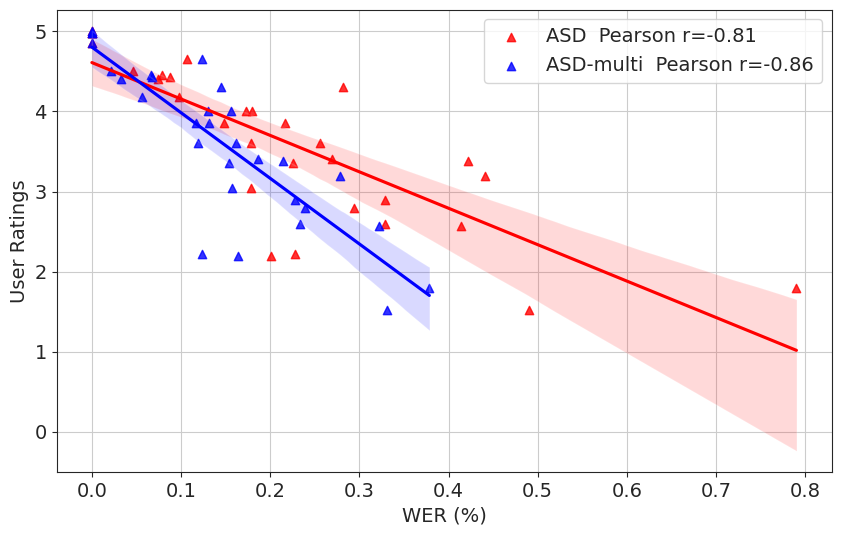

In [17]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
# sns.regplot(x=wer_values, y=user_values, ax=ax, color='g', label='WER  Pearson r={:.2f}'.format(wer_pearson), marker='^')
sns.regplot(x=asd_values, y=user_values, ax=ax, color='r', label='ASD  Pearson r={:.2f}'.format(asd_pearson), marker='^')
sns.regplot(x=asd_multi_values, y=user_values, ax=ax, color='b', label='ASD-multi  Pearson r={:.2f}'.format(asd_multi_pearson), marker='^')
ax.legend(fontsize=14)
ax.set(xlabel='WER (%)', ylabel='User Ratings')
ax.grid()
# plt.savefig('semdist_asd_wer_regplot_v2.png', bbox_inches='tight')
plt.show()

### Individual Ratings

In [ ]:
wer_values = sem_eval_consolidated.wer

matchem_wer_values = sem_eval_consolidated.matchem_wer

# asd_values = sem_eval_consolidated.asd
# asd_first4_values = sem_eval_consolidated.asd_first4
# asd_middle_values = sem_eval_consolidated.asd_middle
# asd_last4_values = sem_eval_consolidated.asd_last4

asd_multi_values = sem_eval_consolidated.asd_multi
asd_multi_first4_values = sem_eval_consolidated.asd_multi_first4
asd_multi_middle_values = sem_eval_consolidated.asd_multi_middle
asd_multi_last4_values = sem_eval_consolidated.asd_multi_last4

asd_norbert_values = sem_eval_consolidated.asd_norbert
asd_norbert2_values = sem_eval_consolidated.asd_norbert2

user_values = sem_eval_consolidated.user_rating

wer_pearson = stats.pearsonr(user_values, wer_values)[0]

matchem_wer_pearson = stats.pearsonr(user_values, matchem_wer_values)[0]

# asd_pearson = stats.pearsonr(user_values, asd_values)[0]
# asd_first4_pearson = stats.pearsonr(user_values, asd_first4_values)[0]
# asd_middle_pearson = stats.pearsonr(user_values, asd_middle_values)[0]
# asd_last4_pearson = stats.pearsonr(user_values, asd_last4_values)[0]

asd_multi_pearson = stats.pearsonr(user_values, asd_multi_values)[0]
asd_multi_first4_pearson = stats.pearsonr(user_values, asd_multi_first4_values)[0]
asd_multi_middle_pearson = stats.pearsonr(user_values, asd_multi_middle_values)[0]
asd_multi_last4_pearson = stats.pearsonr(user_values, asd_multi_last4_values)[0]

asd_norbert_pearson = stats.pearsonr(user_values, asd_norbert_values)[0]
asd_norbert2_pearson = stats.pearsonr(user_values, asd_norbert2_values)[0]



print("INDIVIDUAL USER RATING CORRELATION\n")

print(f"WER: {wer_pearson:.4f}")
print(f"Match-em WER: {matchem_wer_pearson:.4f}\n")

print(f"ASD-NorBERTv1:{asd_norbert_pearson:.4f}")
print(f"ASD-NorBERTv2:{asd_norbert2_pearson:.4f}\n")

print(f"ASD-multi: {asd_multi_pearson:.4f}")
print(f"ASD-multi-first4: {asd_multi_first4_pearson:.4f}")
print(f"ASD-multi-middle: {asd_multi_middle_pearson:.4f}")
print(f"ASD-multi-last4: {asd_multi_last4_pearson:.4f}")

INDIVIDUAL USER RATING CORRELATION

WER: -0.6040
Match-em WER: -0.6436

ASD-NorBERTv1:-0.6460
ASD-NorBERTv2:-0.6606

ASD-multi: -0.6826
ASD-multi-first4: -0.6590
ASD-multi-middle: -0.6981
ASD-multi-last4: -0.6838


In [32]:
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(10, 6)
# sns.regplot(x=asd_values, y=user_values, ax=ax, color='g', label='ASD  Pearson r={:.2f}'.format(asd_pearson), marker='^')
# sns.regplot(x=asd_multi_values, y=user_values, ax=ax, color='r', label='ASD-multi  Pearson r={:.2f}'.format(asd_multi_pearson), marker='^')
# ax.legend(fontsize=14)
# ax.set(xlabel='Semantic Distance', ylabel='User Ratings')
# ax.grid()
# plt.show()
# # plt.savefig('semdist_asd_wer_regplot_v2.png', bbox_inches='tight')

In [9]:
# BOXPLOTS
options = ["ASD-NorBERT", "ASD-NorBERT first4", "ASD-NorBERT last4"]
sem_eval_asd_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

options = ["ASD-multiBERT", "ASD-multiBERT first4", "ASD-multiBERT middle", "ASD-multiBERT last4", ]
sem_eval_asdmulti_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

# options = ["ASD-NorBERT", "ASD-multiBERT"]
options = ["ASD-NorBERTv1", "ASD-NorBERTv2", "ASD-multiBERT"]
sem_eval_versusLM_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

options = ["WER", "Match-em WER"]
sem_eval_justWER_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

In [17]:
# plt.rcParams.update({'font.size': 12})
# order = reversed(sorted(sem_eval_asd_forboxplot["user_rating"].unique()))
# plt.figure(figsize=(8,5))
# sns.boxplot(data=sem_eval_asd_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order, orient="h", palette="mako")
# plt.xlabel('ASD-NorBERT distance')
# plt.ylabel('Survey Scores')
# plt.tight_layout()
# plt.grid()
# plt.savefig('./interspeech2023_plots/ASD_vs_output_layers.pdf')

In [31]:
# plt.rcParams.update({'font.size': 12}
# order = reversed(sorted(sem_eval_asdmulti_forboxplot["user_rating"].unique()))
# plt.figure(figsize=(8,5))
# sns.boxplot(data=sem_eval_asdmulti_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order, orient="h", palette="viridis")
# # sns.boxplot(data=sem_eval_asdmulti_forboxplot.round(2), x="user_rating", y="metric_score", hue="metric_type")
# plt.xlabel('ASD-multiBERT distance')
# plt.ylabel('Survey Scores')
# plt.tight_layout()
# plt.legend(loc="best")
# plt.grid()
# plt.savefig('./interspeech2023_plots/ASDmulti_vs_output_layers.pdf')

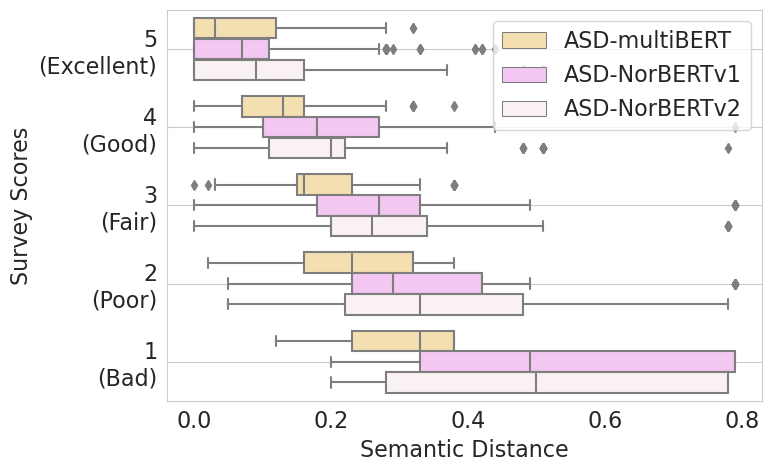

In [10]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 16})
# my_pal = {"ASD-NorBERT":"#fac0f9", "ASD-multiBERT":"#ffe3a6"}
my_pal = {"ASD-NorBERTv1":"#fac0f9", "ASD-NorBERTv2":"#fbf0f1", "ASD-multiBERT":"#ffe3a6"}
order = reversed(sorted(sem_eval_versusLM_forboxplot["user_rating"].unique()))
ylabels = ["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"]
ylabels.reverse()

plt.figure(figsize=(8,5))
sns.boxplot(data=sem_eval_versusLM_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order, orient="h", palette=my_pal)
plt.xlabel('Semantic Distance')
plt.ylabel('Survey Scores')
plt.yticks(np.arange(5), labels=ylabels)
plt.tight_layout()
plt.grid()
plt.legend(loc="best")
# plt.savefig('./interspeech2023_plots/ASD_ASDmulti_vs_user_ratings.pdf')

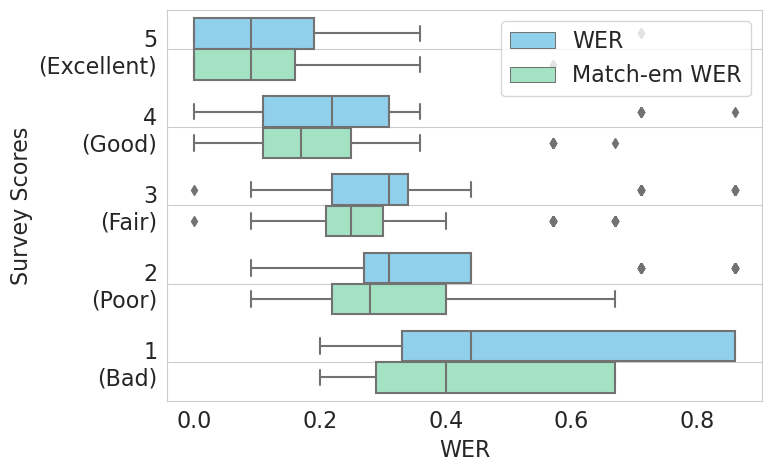

In [11]:
plt.rcParams.update({'font.size': 16})
my_pal = {"WER": "#82d6fa", "Match-em WER": "#99edc3"}
order = reversed(sorted(sem_eval_justWER_forboxplot["user_rating"].unique()))
ylabels = ["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"]
ylabels.reverse()

plt.figure(figsize=(8,5))
sns.boxplot(data=sem_eval_justWER_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order, orient="h", palette=my_pal)
plt.xlabel('WER')
plt.ylabel('Survey Scores')
plt.yticks(np.arange(5), labels=ylabels)
plt.tight_layout()
plt.grid()
plt.legend(loc="best")
# plt.savefig('./interspeech2023_plots/WER_vs_user_ratings.pdf')

In [16]:
# plt.rcParams.update({'font.size': 14})
# order_norbert = reversed(sorted(sem_eval_asd_forboxplot["user_rating"].unique()))
# order_multibert = reversed(sorted(sem_eval_asdmulti_forboxplot["user_rating"].unique()))
# # fig, ax = plt.subplots(1, 2, figsize=(16,8))
# fig, ax = plt.subplots(ncols=2, figsize=(16,8))
# # fig.suptitle('Distance metric vs utterance length')
# sns.boxplot(data=sem_eval_asd_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order_norbert, orient="h", palette="mako", ax=ax[0])
# ax[0].set_xlabel('Semantic Distance')
# ax[0].set_ylabel('Survey Scores')
# ax[0].set_title('ASD-NorBERT')
# plt.tight_layout()
# plt.grid()
# sns.boxplot(data=sem_eval_asdmulti_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order_multibert, orient="h", palette="mako", ax=ax[1])
# ax[1].set_xlabel('Semantic Distance')
# ax[1].set_ylabel('')
# ax[1].set_title('ASD-multiBERT')
# plt.tight_layout()
# plt.grid()
# plt.savefig('./interspeech2023_plots/ASD_vs_output_layers.pdf')

### Inspecting diff between NorBERT and multi

In [ ]:
vocabulary = asd_tokenizer.vocab

wordpiece_counter = 0
unused_token_counter = 0
for key, value in vocabulary.items():
    if "##" in key:
        wordpiece_counter += 1
    if "unused" in key:
        unused_token_counter += 1
print(f"Total wordpieces: {wordpiece_counter}")
print(f"Total unused tokens: {unused_token_counter}")

Total wordpieces: 9245
Total unused tokens: 4334


In [ ]:
vocabulary = asd_multi_tokenizer.vocab

wordpiece_counter = 0
unused_token_counter = 0
for key, value in vocabulary.items():
    if "##" in key:
        wordpiece_counter += 1
    if "unused" in key:
        unused_token_counter += 1
print(f"Total wordpieces: {wordpiece_counter}")
print(f"Total unused tokens: {unused_token_counter}")

Total wordpieces: 43606
Total unused tokens: 99


In [ ]:
# INSPECTING THE ASD METRICS AT THE LOWEST SURVEY SCORE OF 1(BAD)

sem_eval_rating1 = sem_eval_consolidated[sem_eval_consolidated["user_rating"] == 1]
sem_eval_rating1.drop(["asd_first4", "asd_middle", "asd_last4", "asd_multi_first4", "asd_multi_middle", "asd_multi_last4"], axis="columns", inplace=True)
sem_eval_rating1.drop_duplicates(["ref_text"], inplace=True)

for row in sem_eval_rating1.itertuples():

    print("---ASD-NorBERT---")
    tokenized_ref = asd_tokenizer(row.ref_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_tokenizer(row.asr_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, asd_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(asd_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("---ASD-multiBERT---")
    tokenized_ref = asd_multi_tokenizer(row.ref_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_multi_tokenizer(row.asr_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, asd_multi_model)
    print(f"ASD-multiBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(asd_multi_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("===================\n\n")

---ASD-NorBERT---
ASD-NorBERT ref len: 9, ASD=0.41
Token alignment table:


REF:,[CLS],[CLS],derfor,fremmer,vi,dette,forslaget,i,dag,[SEP]
HYP:,[CLS],og,derfor,fremmet,fremmet,dette,forslaget,da,da,[SEP]
CosDist:,0.127,0.441,0.14,0.17,0.539,0.052,0.047,0.464,0.54,0.165


---ASD-multiBERT---
ASD-multiBERT ref len: 11, ASD=0.32
Token alignment table:


REF:,[CLS],[CLS],derfor,frem,##mer,vi,dette,for,##slaget,i,dag,[SEP]
HYP:,[CLS],og,derfor,frem,##met,##met,dette,for,##slaget,da,da,[SEP]
CosDist:,0.056,0.454,0.103,0.059,0.317,0.49,0.04,0.019,0.022,0.429,0.42,0.069




---ASD-NorBERT---
ASD-NorBERT ref len: 21, ASD=0.49
Token alignment table:


REF:,[CLS],så,under,under,fly,##hjul,##hjul,##ene,##ene,så,vil,det,faktisk,være,seks,hundre,meter,med,is,på,en,isb,##re,[SEP]
HYP:,[CLS],så,Inne,##r,fly,fly,##ord,##rene,som,som,ville,ville,faktisk,bare,seks,hundre,meter,med,i,på,en,isb,##re,[SEP]
CosDist:,0.05,0.153,0.567,0.564,0.195,0.567,0.685,0.399,0.496,0.501,0.384,0.599,0.155,0.483,0.073,0.043,0.075,0.166,0.515,0.109,0.028,0.023,0.02,0.023


---ASD-multiBERT---
ASD-multiBERT ref len: 24, ASD=0.33
Token alignment table:


REF:,[CLS],så,under,fly,##h,##jul,##ene,så,vil,det,fakt,##isk,være,seks,hun,##dre,meter,med,med,is,på,en,is,##bre,[SEP]
HYP:,[CLS],så,Inner,fly,##ord,##ord,##rene,som,ville,ville,fakt,##isk,bare,seks,hun,##dre,meter,med,i,i,på,en,is,##bre,[SEP]
CosDist:,0.019,0.082,0.389,0.112,0.514,0.58,0.272,0.398,0.288,0.518,0.051,0.053,0.409,0.031,0.023,0.019,0.036,0.123,0.399,0.47,0.077,0.029,0.03,0.024,0.019




---ASD-NorBERT---
ASD-NorBERT ref len: 21, ASD=0.23
Token alignment table:


REF:,[CLS],Fremskrittspartiet,ser,ikke,ut,til,å,forstå,at,forslaget,deres,innebærer,at,også,eiendomsskatt,##en,på,kraftverk,skal,vekk,[SEP]
HYP:,[CLS],Fremskrittsparti,ser,ser,ut,og,og,forstå,at,forslaget,om,innebærer,at,også,eiendomsskatt,##en,på,kraftverk,skal,vekk,[SEP]
CosDist:,0.035,0.192,0.067,0.484,0.121,0.394,0.412,0.142,0.072,0.083,0.453,0.117,0.054,0.025,0.025,0.027,0.024,0.02,0.023,0.019,0.068


---ASD-multiBERT---
ASD-multiBERT ref len: 34, ASD=0.12
Token alignment table:


REF:,[CLS],Fr,##ems,##krit,##ts,##partiet,ser,ikke,ut,til,å,for,##stå,at,for,##slaget,deres,inne,##b,##ærer,at,også,eie,##ndom,##ss,##kat,##ten,på,kraft,##verk,skal,vek,##k,[SEP]
HYP:,[CLS],Fr,##ems,##krit,##ts,##parti,ser,ser,ut,og,og,for,##stå,at,for,##slaget,om,inne,##b,##ærer,at,også,eie,##ndom,##ss,##kat,##ten,på,kraft,##verk,skal,vek,##k,[SEP]
CosDist:,0.009,0.019,0.026,0.025,0.039,0.202,0.049,0.441,0.095,0.362,0.368,0.05,0.056,0.033,0.023,0.049,0.44,0.036,0.02,0.02,0.013,0.009,0.01,0.009,0.011,0.008,0.009,0.011,0.011,0.012,0.008,0.008,0.008,0.01




---ASD-NorBERT---
ASD-NorBERT ref len: 38, ASD=0.20
Token alignment table:


REF:,[CLS],og,da,velger,jeg,heller,å,fra,##vik,##e,prinsippet,om,kommunene,##s,selv,##råder,##ett,og,si,klart,ifra,til,de,lokalpoliti,##kerne,som,ikke,vil,prioritere,at,nå,må,de,begynne,å,gjøre,det,[SEP]
HYP:,[CLS],[CLS],da,Belgia,Belgia,heller,å,fra,##vik,##e,prinsippet,om,kommunene,kommunene,selv,##råder,##ett,og,si,klart,ifra,til,be,lokalpoliti,##kerne,som,ikke,vil,prioritere,at,nå,må,må,begynne,å,gjøre,det,[SEP]
CosDist:,0.033,0.486,0.17,0.53,0.578,0.086,0.109,0.043,0.035,0.044,0.036,0.054,0.079,0.489,0.069,0.042,0.041,0.035,0.036,0.033,0.037,0.067,0.426,0.065,0.052,0.042,0.038,0.035,0.034,0.108,0.088,0.093,0.538,0.065,0.06,0.037,0.035,0.03


---ASD-multiBERT---
ASD-multiBERT ref len: 46, ASD=0.16
Token alignment table:


REF:,[CLS],og,da,vel,##ger,jeg,jeg,heller,å,fra,##vik,##e,prinsip,##pet,om,kommunen,##es,selv,##råde,##rett,og,si,klart,if,##ra,til,de,lokal,##politik,##erne,som,ikke,vil,prior,##iter,##e,at,nå,må,de,be,##gy,##nne,å,gjøre,det,[SEP]
HYP:,[CLS],da,da,da,da,da,Belgia,heller,å,fra,##vik,##e,prinsip,##pet,om,kommunen,##e,selv,##råde,##rett,og,si,klart,if,##ra,til,be,lokal,##politik,##erne,som,ikke,vil,prior,##iter,##e,at,nå,må,må,be,##gy,##nne,å,gjøre,det,[SEP]
CosDist:,0.041,0.291,0.152,0.566,0.486,0.533,0.534,0.086,0.048,0.021,0.022,0.032,0.024,0.022,0.032,0.056,0.239,0.046,0.028,0.044,0.028,0.028,0.028,0.035,0.042,0.092,0.49,0.1,0.032,0.04,0.027,0.017,0.018,0.016,0.014,0.015,0.033,0.032,0.082,0.51,0.048,0.027,0.031,0.025,0.025,0.02,0.03




---ASD-NorBERT---
ASD-NorBERT ref len: 66, ASD=0.29
Token alignment table:


REF:,[CLS],og,så,hadde,vi,jo,lyst,til,å,være,på,hytta,i,sommer,da,og,kose,oss,og,og,ta,fjell,##tur,##er,og,diverse,sånt,og,sykkel,##tur,##er,hadde,vi,lyst,til,å,ta,over,så,vi,tok,en,sykkel,##tur,da,som,ute,på,så,vart,ute,på,Hit,##ra,og,Frøy,##a,og,utover,til,Mau,##sund,##vær,og,Sul,##a,[SEP]
HYP:,[CLS],også,også,hadde,vi,jo,lyst,og,og,vær,på,hytta,i,sommer,lå,og,kose,så,så,vær,ta,fjell,##tur,##er,og,diverse,sånt,og,sykkel,##tur,og,hadde,hadde,lyst,til,å,ta,hvitt,så,så,tok,en,sykkel,##tur,##tur,som,ute,på,så,vært,ute,på,Hit,##ra,##ra,Frøy,##a,og,utover,te,Mau,##sund,##vær,og,Sul,##a,[SEP]
CosDist:,0.023,0.309,0.426,0.084,0.052,0.039,0.118,0.391,0.416,0.398,0.102,0.041,0.049,0.066,0.375,0.18,0.224,0.55,0.49,0.524,0.15,0.034,0.031,0.037,0.043,0.044,0.04,0.085,0.041,0.095,0.448,0.157,0.539,0.081,0.076,0.099,0.126,0.455,0.162,0.555,0.18,0.091,0.044,0.05,0.642,0.14,0.057,0.076,0.124,0.327,0.076,0.069,0.049,0.124,0.494,0.085,0.06,0.064,0.086,0.417,0.067,0.05,0.048,0.053,0.036,0.046,0.038


---ASD-multiBERT---
ASD-multiBERT ref len: 75, ASD=0.24
Token alignment table:


REF:,[CLS],og,så,hadde,vi,jo,lys,##t,til,å,å,være,på,hy,##tta,i,somme,##r,da,og,ko,##se,oss,og,og,og,ta,fjell,##ture,##r,og,diverse,så,##nt,og,sy,##kkel,##ture,##r,##r,hadde,vi,lys,##t,til,å,ta,over,over,over,så,vi,tok,en,sy,##kkel,##tur,da,som,ute,på,så,vart,ute,på,Hit,##ra,og,Fr,##øya,og,ut,##over,til,til,Mau,##sund,##vær,og,Sul,##a,[SEP]
HYP:,[CLS],også,også,hadde,vi,jo,lys,##t,og,og,v,##ær,på,hy,##tta,i,somme,##r,lå,og,ko,##se,##se,så,v,##ær,ta,fjell,##ture,##r,og,diverse,så,##nt,og,sy,##kkel,##tur,##tur,og,hadde,hadde,lys,##t,til,å,ta,ta,h,##vitt,så,så,tok,en,sy,##kkel,##tur,##tur,som,ute,på,så,vært,ute,på,Hit,##ra,##ra,Fr,##øya,og,ut,##over,##over,te,Mau,##sund,##vær,og,Sul,##a,[SEP]
CosDist:,0.055,0.236,0.383,0.045,0.041,0.036,0.061,0.078,0.399,0.44,0.553,0.502,0.068,0.022,0.025,0.031,0.025,0.046,0.424,0.086,0.041,0.068,0.556,0.44,0.502,0.473,0.051,0.018,0.015,0.018,0.025,0.022,0.02,0.019,0.034,0.017,0.029,0.245,0.397,0.403,0.106,0.506,0.042,0.036,0.048,0.038,0.085,0.504,0.525,0.627,0.076,0.455,0.054,0.031,0.02,0.02,0.032,0.485,0.092,0.032,0.032,0.06,0.327,0.037,0.026,0.032,0.084,0.405,0.058,0.033,0.033,0.036,0.066,0.403,0.422,0.033,0.029,0.024,0.035,0.023,0.036,0.024




---ASD-NorBERT---
ASD-NorBERT ref len: 9, ASD=0.79
Token alignment table:


REF:,[CLS],jeg,jeg,jeg,merket,meg,meg,også,svaret,fra,fra,statsråden,[SEP]
HYP:,[CLS],og,president,##er,merk,##a,med,og,svaret,fra,fra,statsråden,[SEP]
CosDist:,0.153,0.473,0.608,0.58,0.479,0.581,0.585,0.471,0.124,0.151,0.139,0.135,0.109


---ASD-multiBERT---
ASD-multiBERT ref len: 13, ASD=0.38
Token alignment table:


REF:,[CLS],jeg,jeg,jeg,merk,##et,meg,også,sva,##ret,fra,fra,stat,##sråd,##en,[SEP]
HYP:,[CLS],og,presidente,##r,merk,##a,med,og,sva,##ret,fra,fra,stat,##sråd,##en,[SEP]
CosDist:,0.041,0.349,0.539,0.477,0.085,0.316,0.412,0.386,0.058,0.075,0.097,0.063,0.03,0.03,0.032,0.029




---ASD-NorBERT---
ASD-NorBERT ref len: 38, ASD=0.33
Token alignment table:


REF:,[CLS],sommeren,to,tusen,og,tre,holdt,past,##or,##or,Å,##ke,Gren,i,pin,##sem,##sem,##en,##igheten,i,Borg,##holm,på,Øl,##and,en,pre,##ken,der,han,gikk,til,angrep,mot,de,hom,##ose,##ks,##uelle,[SEP]
HYP:,[CLS],sommeren,to,tusen,tusen,tre,holdt,past,##or,og,og,og,Gren,##i,pin,##se,menighet,##en,##en,i,Borg,hånd,på,Ør,##land,en,pre,##ken,der,han,gikk,til,angrep,mot,mot,hom,##ose,##ks,##uelle,[SEP]
CosDist:,0.012,0.036,0.05,0.126,0.509,0.2,0.024,0.036,0.083,0.525,0.599,0.644,0.277,0.468,0.128,0.507,0.634,0.281,0.44,0.077,0.205,0.528,0.116,0.473,0.321,0.032,0.022,0.029,0.018,0.027,0.018,0.022,0.023,0.027,0.448,0.039,0.036,0.029,0.044,0.037


---ASD-multiBERT---
ASD-multiBERT ref len: 39, ASD=0.23
Token alignment table:


REF:,[CLS],sommeren,to,tu,##sen,og,tre,holdt,pastor,Å,##ke,G,##ren,i,pin,##sem,##eni,##ghet,##en,i,Borg,##holm,##holm,##holm,på,Ø,##land,en,pre,##ken,der,han,gikk,til,angrep,mot,de,homo,##seks,##uelle,[SEP]
HYP:,[CLS],sommeren,to,tu,##sen,##sen,tre,holdt,pastor,og,og,G,##ren,##i,pin,##se,meni,##ghet,##en,i,Borg,Borg,h,##ånd,på,Ø,##rland,en,pre,##ken,der,han,gikk,til,angrep,mot,mot,homo,##seks,##uelle,[SEP]
CosDist:,0.004,0.004,0.016,0.021,0.066,0.392,0.077,0.017,0.068,0.462,0.477,0.104,0.15,0.424,0.083,0.439,0.42,0.081,0.046,0.025,0.086,0.394,0.523,0.519,0.037,0.063,0.251,0.013,0.007,0.007,0.007,0.011,0.005,0.005,0.007,0.02,0.426,0.015,0.013,0.024,0.006




---ASD-NorBERT---
ASD-NorBERT ref len: 43, ASD=0.33
Token alignment table:


REF:,[CLS],kanskje,noe,av,det,mest,spennende,jeg,har,gjort,er,å,være,være,tilknyttet,senter,for,borgerkrig,##sforsk,##ning,som,var,var,ett,av,de,såkalte,såkalte,senter,for,frem,##rag,##ende,##ende,##ende,forskning,som,ble,ble,ledet,av,institutt,for,fred,##sforsk,##ning,##ning,i,Oslo,[SEP]
HYP:,[CLS],kanskje,noe,er,er,mest,spennende,jeg,har,gjort,er,er,er,nær,tilknyttet,senter,for,borgerkrig,##sforsk,##ning,som,var,etter,etter,etter,de,såkalte,sendt,sendt,sendt,frem,##rag,##ende,senter,for,forskning,som,som,bel,##eiret,av,institutt,for,fred,##sforsk,##ning,og,i,Oslo,[SEP]
CosDist:,0.042,0.04,0.099,0.36,0.363,0.074,0.044,0.026,0.029,0.04,0.123,0.435,0.346,0.537,0.135,0.042,0.035,0.059,0.035,0.032,0.054,0.131,0.531,0.606,0.577,0.139,0.13,0.489,0.585,0.585,0.099,0.074,0.12,0.646,0.476,0.06,0.138,0.432,0.571,0.513,0.13,0.042,0.039,0.031,0.034,0.058,0.516,0.122,0.057,0.062


---ASD-multiBERT---
ASD-multiBERT ref len: 52, ASD=0.23
Token alignment table:


REF:,[CLS],kanskje,noe,av,det,mest,sp,##enne,##nde,jeg,har,gjort,er,å,være,være,tilknyttet,sente,##r,for,bor,##ger,##kr,##ig,##s,##fors,##kning,som,var,ett,av,de,såkalte,såkalte,såkalte,såkalte,sente,##r,for,frem,##ragende,forskning,som,ble,ble,ble,ledet,av,institut,##t,for,fred,##s,##fors,##kning,##kning,i,Oslo,[SEP]
HYP:,[CLS],kanskje,noe,er,er,mest,sp,##enne,##nde,jeg,har,gjort,er,er,er,nær,tilknyttet,sente,##r,for,bor,##ger,##kr,##ig,##s,##fors,##kning,som,var,var,etter,de,såkalte,sendt,frem,##ragende,sente,##r,for,for,for,forskning,som,som,bel,##eir,##et,av,institut,##t,for,fred,##s,##fors,##kning,og,i,Oslo,[SEP]
CosDist:,0.012,0.025,0.071,0.34,0.415,0.061,0.029,0.023,0.042,0.033,0.03,0.036,0.111,0.486,0.341,0.473,0.074,0.019,0.02,0.014,0.011,0.012,0.012,0.011,0.012,0.01,0.01,0.025,0.077,0.488,0.489,0.116,0.107,0.48,0.553,0.515,0.031,0.051,0.043,0.492,0.44,0.033,0.091,0.364,0.479,0.589,0.377,0.06,0.019,0.021,0.016,0.016,0.016,0.016,0.033,0.487,0.09,0.017,0.012




---ASD-NorBERT---
ASD-NorBERT ref len: 9, ASD=0.44
Token alignment table:


REF:,[CLS],takk,skal,du,ha,Trygve,Heg,##nar,[SEP]
HYP:,[CLS],takk,skal,du,av,Trygve,Ay,##na,[SEP]
CosDist:,0.062,0.047,0.081,0.082,0.511,0.184,0.549,0.455,0.045


---ASD-multiBERT---
ASD-multiBERT ref len: 12, ASD=0.28
Token alignment table:


REF:,[CLS],tak,##k,skal,du,ha,Try,##g,##ve,He,##gnar,[SEP]
HYP:,[CLS],tak,##k,skal,du,av,Try,##g,##ve,Ayn,##a,[SEP]
CosDist:,0.036,0.025,0.023,0.023,0.041,0.409,0.06,0.041,0.048,0.505,0.437,0.038




---ASD-NorBERT---
ASD-NorBERT ref len: 11, ASD=0.23
Token alignment table:


REF:,[CLS],og,jeg,er,ikke,så,liten,og,lett,heller,[SEP]
HYP:,[CLS],og,og,er,ikke,så,liten,liten,lett,heller,[SEP]
CosDist:,0.051,0.114,0.462,0.115,0.047,0.044,0.144,0.584,0.145,0.04,0.043


---ASD-multiBERT---
ASD-multiBERT ref len: 11, ASD=0.15
Token alignment table:


REF:,[CLS],og,jeg,er,ikke,så,liten,og,lett,heller,[SEP]
HYP:,[CLS],og,og,er,ikke,så,liten,liten,lett,heller,[SEP]
CosDist:,0.04,0.088,0.38,0.069,0.038,0.028,0.048,0.45,0.066,0.039,0.039


### Linear Regression Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# metric_list = ["wer", "matchem_wer", "asd", "asd_multi", "asd_multi_middle"]
metric_list = ["wer", "matchem_wer", "asd_norbert", "asd_norbert2", "asd_multi", "asd_multi_middle"]

data_train = []
data_test = []

for metric in metric_list:
    X = sem_eval_consolidated[[metric]]
    Y = sem_eval_consolidated.user_rating

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)

    # results on train set
    Y_pred_train = model.predict(X_train)
    data_train.append([metric.upper(), mean_squared_error(Y_train, Y_pred_train),
                 mean_absolute_error(Y_train, Y_pred_train), r2_score(Y_train, Y_pred_train)])

    # results on test set
    Y_pred_test = model.predict(X_test)
    data_test.append([metric.upper(), mean_squared_error(Y_test, Y_pred_test),
                 mean_absolute_error(Y_test, Y_pred_test), r2_score(Y_test, Y_pred_test)])


linreg_test_results = pd.DataFrame(data_test, columns=["metric", "MSE", "MAE", "R2"])
linreg_test_results.sort_values("MSE", axis="index", ascending=True)

,metric,MSE,MAE,R2
5,ASD_MULTI_MIDDLE,0.801911,0.701269,0.463380
4,ASD_MULTI,0.824232,0.715716,0.448444
3,ASD_NORBERT2,0.865872,0.740299,0.420579
1,MATCHEM_WER,0.911413,0.757062,0.390104
2,ASD_NORBERT,0.936702,0.776248,0.373181
0,WER,0.981390,0.791982,0.343278


In [ ]:
# metric_list = [["wer", "asd"], ["wer", "asd_multi"], ["wer", "asd_multi_middle"]]
metric_list = [["wer", "asd_norbert"], ["wer", "asd_norbert2"], ["wer", "asd_multi"], ["wer", "asd_multi_middle"],
              ["matchem_wer", "asd_norbert"], ["matchem_wer", "asd_norbert2"], ["matchem_wer", "asd_multi"], ["matchem_wer", "asd_multi_middle"]]

data_train = []
data_test = []

for metric in metric_list:
    X = sem_eval_consolidated[metric]
    Y = sem_eval_consolidated.user_rating

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)

    # results on train set
    Y_pred_train = model.predict(X_train)
    data_train.append([(metric[0] + "+" + metric[1]).upper(), mean_squared_error(Y_train, Y_pred_train),
                 mean_absolute_error(Y_train, Y_pred_train), r2_score(Y_train, Y_pred_train)])

    # results on test set
    Y_pred_test = model.predict(X_test)
    data_test.append([(metric[0] + "+" + metric[1]).upper(), mean_squared_error(Y_test, Y_pred_test),
                 mean_absolute_error(Y_test, Y_pred_test), r2_score(Y_test, Y_pred_test)])


linreg_test_results = pd.DataFrame(data_test, columns=["metric", "MSE", "MAE", "R2"])
linreg_test_results.sort_values("MSE", axis="index", ascending=True)

,metric,MSE,MAE,R2
3,WER+ASD_MULTI_MIDDLE,0.786186,0.696261,0.473903
7,MATCHEM_WER+ASD_MULTI_MIDDLE,0.799243,0.700422,0.465166
2,WER+ASD_MULTI,0.817658,0.712006,0.452843
6,MATCHEM_WER+ASD_MULTI,0.824480,0.715513,0.448278
1,WER+ASD_NORBERT2,0.862174,0.738728,0.423054
5,MATCHEM_WER+ASD_NORBERT2,0.865239,0.736666,0.421003
4,MATCHEM_WER+ASD_NORBERT,0.907748,0.756671,0.392557
0,WER+ASD_NORBERT,0.933479,0.774062,0.375338


### Bayesian Classifier

In [ ]:
# 10-FOLD STRATIFIED
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

plt.rcParams.update({'font.size': 14})

# metric_list = ["wer", "matchem_wer", "asd", "asd_multi", "asd_multi_middle"]
metric_list = ["wer", "matchem_wer", "asd_norbert", "asd_norbert2", "asd_multi", "asd_multi_middle"]
gnb = GaussianNB()

for metric in metric_list:

    if metric == "wer":
        plot_title = "WER"
    elif metric == "matchem_wer":
        plot_title = "Match-em WER"
    elif metric == "asd":
        plot_title = "ASD-NorBERT"
    elif metric == "asd_norbert":
        plot_title = "ASD-NorBERT v1"
    elif metric == "asd_norbert2":
        plot_title = "ASD-NorBERT v2"
    elif metric == "asd_multi":
        plot_title = "ASD-multiBERT"
    elif metric == "asd_multi_middle":
        plot_title = "ASD-multiBERT(5-8)"

    metric_col = sem_eval_consolidated.columns.get_loc(metric)
    X = sem_eval_consolidated.iloc[:,metric_col]
    y = sem_eval_consolidated.user_rating

    accuracy_score = np.zeros(10)
    mse_score = np.zeros(10)
    confusion_matrices = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    i = 0
    for train, test in skf.split(X,y):
        # print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))
        X_train = X[train].to_numpy().reshape(-1, 1)
        X_test = X[test].to_numpy().reshape(-1, 1)
        y_train = y[train].to_numpy()
        y_test = y[test].to_numpy()
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        accuracy_score[i] = metrics.balanced_accuracy_score(y_test, y_pred)
        mse_score[i] = metrics.mean_squared_error(y_test, y_pred)
        confusion_matrices.append(metrics.confusion_matrix(y_test, y_pred))
        i += 1

    print('STRATIFIED K-FOLD\n------\n', metric.upper())
    print(f'{accuracy_score.mean():.3f} accuracy with a standard deviation of {accuracy_score.std():.3f}')
    print(f'{mse_score.mean():.3f} MSE with a standard deviation of {mse_score.std():.3f}')

    cm_mean = np.mean(np.array(confusion_matrices), axis=0)
    cm_mean_normalized = cm_mean / cm_mean.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_mean_normalized, vmin=0, vmax=1, linecolor="white",
                annot=True, fmt=".2f", linewidth=0.5, cmap="Blues",
                xticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"],
                yticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(plot_title)
    plt.tight_layout()
    # plt.savefig('./interspeech2023_plots/cm_10foldstratified_'+metric+'.pdf')
    plt.show()


NameError: name 'plt' is not defined

In [ ]:
# # 10-FOLD CROSS-VALIDATION & PREDICTION
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.naive_bayes import GaussianNB
# from sklearn import metrics

# metric_list = ["wer", "matchem_wer", "asd", "asd_multi", "asd_multi_middle"]
# gnb = GaussianNB()

# for metric in metric_list:

#     if metric == "wer":
#         plot_title = "WER"
#     elif metric == "matchem_wer":
#         plot_title = "Match-em WER"
#     elif metric == "asd":
#         plot_title = "ASD-NorBERT"
#     elif metric == "asd_multi":
#         plot_title = "ASD-multiBERT"
#     elif metric == "asd_multi_middle":
#         plot_title = "ASD-multiBERT(5-8)"

#     X = sem_eval_consolidated[[metric]]
#     y = sem_eval_consolidated.user_rating

#     kf = KFold(n_splits=10, shuffle=True, random_state=42)

#     X_train_idx = []
#     X_test_idx = []
#     for train, test in kf.split(X):
#         X_train_idx.append(train)
#         X_test_idx.append(test)

#     y_train_idx = []
#     y_test_idx = []
#     for train, test in kf.split(y):
#         y_train_idx.append(train)
#         y_test_idx.append(test)

#     accuracy_score = np.zeros(10)
#     y_test_list = []
#     y_pred_list = []
#     confusion_matrices = []
#     for i in range(0, len(X_train_idx)):
#         X_train = X.loc[X_train_idx[i]]
#         X_test = X.loc[X_test_idx[i]]
#         y_train = y.loc[y_train_idx[i]]
#         y_test = y.loc[y_test_idx[i]]

#         y_pred = gnb.fit(X_train, y_train).predict(X_test)
#         y_test_list.append(y_test)
#         y_pred_list.append(y_pred)
#         accuracy_score[i] = metrics.balanced_accuracy_score(y_test, y_pred)  # used balanced accuracy score because of unbalanced dataset
#         confusion_matrices.append(metrics.confusion_matrix(y_test, y_pred))

#     print('\n------\n', metric.upper())
#     print(f'{accuracy_score.mean():.2f} accuracy with a standard deviation of {accuracy_score.std():.2f}')

#     cm_mean = np.mean(np.array(confusion_matrices), axis=0)
#     cm_mean_normalized = cm_mean / cm_mean.sum(axis=1)[:, np.newaxis]
#     sns.heatmap(cm_mean_normalized, vmin=0, vmax=1, linecolor="white",
#                 annot=True, fmt=".2f", linewidth=0.5, cmap="Blues",
#                 xticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"],
#                 yticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"])
#     # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"])
#     # cm_display.plot()
#     plt.xticks(rotation=90)
#     plt.xlabel('Predicted label')
#     plt.ylabel('True label')
#     plt.title(plot_title)
#     plt.tight_layout()
#     plt.savefig('./interspeech2023_plots/cm_10fold_'+metric+'.pdf')
#     plt.show()


### Fleiss' Kappa

In [2]:
survey_res_df = pd.read_csv("./sem_eval_survey/survey_responses_ver3_2023-Feb-14.csv", delimiter=",")
survey_res_df.drop(["respondent"], axis="columns", inplace=True)
survey_res_df

,utt_1,utt_2,utt_3,utt_4,utt_5,utt_6,utt_7,utt_8,utt_9,utt_10,...,utt_21,utt_22,utt_23,utt_24,utt_25,utt_26,utt_27,utt_28,utt_29,utt_30
0,5,2,1,5,4,4,3,2,2,4,...,1,2,4,4,5,2,4,4,3,2
1,5,2,1,5,5,5,4,3,2,2,...,3,2,5,5,5,4,4,5,1,3
2,3,3,1,4,4,2,2,4,2,3,...,3,2,4,5,5,4,3,3,2,2
3,5,4,1,4,4,5,3,4,2,3,...,3,3,4,5,5,5,5,5,5,4
4,5,2,1,5,5,5,4,4,2,4,...,3,3,5,5,5,4,5,4,3,3
5,5,3,2,4,4,5,3,3,2,3,...,4,2,4,5,5,4,5,5,4,4
6,5,1,1,4,4,5,4,4,2,4,...,3,2,3,5,5,4,5,5,4,4
7,4,5,3,4,4,4,2,4,3,4,...,3,3,4,4,5,3,4,4,4,4
8,5,3,1,4,3,5,3,4,4,4,...,5,3,5,5,5,5,4,4,5,5
9,5,2,1,4,3,5,2,5,1,5,...,3,5,5,5,5,3,4,5,4,3


In [ ]:
def fleiss_kappa(lists, classes):
    n = len(lists)  # number of raters
    N = len(lists[0])  # number of "subjects"/"utterances"
    k = len(classes)  # number of categories

    nij = []
    for i in range(N):
        nij.append([0]*k)

    for i in range(n):
        for j in range(len(lists[i])):
            nij[j][classes.index(lists[i][j])] += 1

    P = []
    for i in nij:
        P.append((1/(n*(n-1)))*(sum([j*j for j in i])-n))

    Pavg = sum(P)/N
    Pe = sum([y*y for y in [x/(N*n) for x in [sum(i) for i in zip(*nij)]]])
    # kappa = ((Pavg-Pe)/(1-Pe) + 1)/2
    kappa = (Pavg-Pe)/(1-Pe)

    return kappa

    # return (((sum(P)/N)-(sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]])))/(1-sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]]))+1)/2

In [ ]:
(
    ((sum(P)/N)-(sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]])))
    /(1-sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]]))
    + 1
)/2

In [4]:
ratings = []
for i in range(0, len(survey_res_df)):
    ratings.append(survey_res_df.loc[i].values.flatten().tolist())

In [7]:
len(ratings[0])

30

In [8]:
classes = [1, 2, 3, 4, 5]
print(fleiss_kappa(ratings, classes))

0.25543433934352


In [9]:
# other_kappa_calculation = 0.6277171696717601

---
# NLP Settings

In [ ]:
df_file = "./E2E_ASR_results_from_TUL/e2e_segmented/df_e2e_consolidated.csv"

finetuned_bert_ner = "./nlp_models/ner_pos/finetuned_bert_ner_v1"
finetuned_bert_sa = "./nlp_models/sentiment_analysis/finetuned_model"

sclite_path = "../localhome/kaldi/tools/sctk/bin/sclite"
sclite_output_dir = "./sclite_outputs/TUL"

label_list_ner = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-GPE_LOC', 'I-GPE_LOC', 'B-PROD', 'I-PROD', 'B-LOC', 'I-LOC', 'B-GPE_ORG', 'I-GPE_ORG', 'B-DRV', 'I-DRV', 'B-EVT', 'I-EVT', 'B-MISC', 'I-MISC']

f = open("./nlp_models/idx_to_drop.txt", "r")
idx_to_drop = []
for string in f.readlines():
    idx_to_drop.append(int(string))

# for random sampling
random.seed(42)  # originally: 42


In [ ]:
labels = []
for item in label_list_ner:
    if "-" in item:
        labels.append(item.split("-")[1])
    else:
        labels.append(item)
print(set(labels))
print(len(set(labels)))


{'LOC', 'MISC', 'GPE_LOC', 'PROD', 'DRV', 'EVT', 'GPE_ORG', 'ORG', 'O', 'PER'}
10


---
# NER Experiment

## NLP pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(finetuned_bert_ner)
model = AutoModelForTokenClassification.from_pretrained(finetuned_bert_ner)
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

## NER - Original transcriptions (baseline)

In [ ]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_df_ner = get_nlp_tags(tul_asr_df, "ner", nlp_ner)
tul_asr_df_ner_aligned, ___ = get_ner_alignment(tul_asr_df_ner, sclite_output_dir, sclite_path, label_list_ner)

tul_asr_df_ner_aligned["f1_score"] = tul_asr_df_ner_aligned[["ref_labels", "asr_labels"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("TUL ASR baseline - NER")
y_true = list(tul_asr_df_ner_aligned["ref_labels"])
y_pred = list(tul_asr_df_ner_aligned["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_df_ner["wer"].mean())
print("ASD:", tul_asr_df_ner["asd"].mean())

Aligning REF & ASR labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 81944.18it/s]

get alignment - DONE


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR baseline - NER
F1 score micro: 0.8780229945817365
F1 score macro: 0.7897056255121901
WER: 0.07391061189192795
ASD: 0.065827806898373


In [ ]:
# with open("./nlp_models/idx_to_drop.txt", "w") as f:
#     for idx in idx_to_drop:
#         f.write(str(idx) + "\n")

## NER - Modified *worse* ASD

In [ ]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_worseASD_df = get_worse_asd_ner(tul_asr_df, "og")

tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df = get_nlp_tags(tul_asr_worseASD_df, "ner", nlp_ner)
tul_asr_worseASD_df_ner, ___ = get_ner_alignment(tul_asr_worseASD_df, sclite_output_dir, sclite_path, label_list_ner)

tul_asr_worseASD_df_ner["f1_score"] = tul_asr_worseASD_df_ner[["ref_labels", "asr_labels"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("TUL ASR mod worseASD (entity priority) - NER")
y_true = list(tul_asr_worseASD_df_ner["ref_labels"])
y_pred = list(tul_asr_worseASD_df_ner["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_worseASD_df_ner["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_ner["mod_asd"].mean())

Mod Worse ASD: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [05:41<00:00,  7.70it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Aligning REF & ASR labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 84392.31it/s]

get alignment - DONE


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod worseASD (entity priority) - NER
F1 score micro: 0.7038316582914572
F1 score macro: 0.6178748258489628
WER: 0.07392211645924118
ASD: 0.09328804142101155


In [ ]:
# # HYPOTHESIS TESTING, T-TEST FOR F1-SCORE GETTING AFFECTED BY SEMANTIC DISTANCE
# t_value, p_value = stats.ttest_ind(tul_asr_df_ner_aligned["f1_score"], tul_asr_worseASD_df_ner["f1_score"], random_state=42)
# print('Worse ASD (entity priority) T-Test (NER)')
# print('Test statistic is %f' % float("{:.6f}".format(t_value)))
# print('p-value for two tailed test is %f' % p_value)

In [ ]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_worseASD_df = get_worse_asd(tul_asr_df, "og")

tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df = get_nlp_tags(tul_asr_worseASD_df, "ner", nlp_ner)
tul_asr_worseASD_df_ner, ___ = get_ner_alignment(tul_asr_worseASD_df, sclite_output_dir, sclite_path, label_list_ner)

tul_asr_worseASD_df_ner["f1_score"] = tul_asr_worseASD_df_ner[["ref_labels", "asr_labels"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("TUL ASR mod worseASD (random) - NER")
y_true = list(tul_asr_worseASD_df_ner["ref_labels"])
y_pred = list(tul_asr_worseASD_df_ner["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_worseASD_df_ner["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_ner["mod_asd"].mean())

Mod Worse ASD: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 228349.90it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Aligning REF & ASR labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 79223.50it/s]

get alignment - DONE


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod worseASD (random) - NER
F1 score micro: 0.8863035430988895
F1 score macro: 0.8336042638788763
WER: 0.07392211645924118
ASD: 0.08027554405126573


In [ ]:
# for row in tul_asr_worseASD_df_ner.itertuples():
#     if (len(row.ref_ner_tags) == 1) & (row.ref_ner_tags[0]["entity_group"] == "LABEL_0"):
#         print(row.ref_ner_tags)

In [ ]:
# HYPOTHESIS TESTING, T-TEST FOR F1-SCORE GETTING AFFECTED BY SEMANTIC DISTANCE
# t_value, p_value = stats.ttest_ind(tul_asr_df_ner_aligned["f1_score"], tul_asr_worseASD_df_ner["f1_score"], random_state=42)
# print('Worse ASD T-Test (NER)')
# print('Test statistic is %f' % float("{:.6f}".format(t_value)))
# print('p-value for two tailed test is %f' % p_value)

## NER - Modified *better* ASD

In [ ]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_betterASD_df = get_better_asd(tul_asr_df, "og")
tul_asr_betterASD_df["mod_wer"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_betterASD_df["mod_asd"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_betterASD_df = get_nlp_tags(tul_asr_betterASD_df, "ner", nlp_ner)
tul_asr_betterASD_df_ner, __ = get_ner_alignment(tul_asr_betterASD_df, sclite_output_dir, sclite_path, label_list_ner)

tul_asr_betterASD_df_ner["f1_score"] = tul_asr_betterASD_df_ner[["ref_labels", "asr_labels"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("TUL ASR mod betterASD - NER")
y_true = list(tul_asr_betterASD_df_ner["ref_labels"])
y_pred = list(tul_asr_betterASD_df_ner["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_betterASD_df_ner["mod_wer"].mean())
print("ASD:", tul_asr_betterASD_df_ner["mod_asd"].mean())

Mod Better ASD: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 269886.33it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Aligning REF & ASR labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2634/2634 [00:00<00:00, 65951.09it/s]

get alignment - DONE


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod betterASD - NER
F1 score micro: 0.9472614055153132
F1 score macro: 0.8882885895313435
WER: 0.07392211645924118
ASD: 0.05095345516813858


In [ ]:
# HYPOTHESIS TESTING, T-TEST FOR F1-SCORE GETTING AFFECTED BY SEMANTIC DISTANCE
t_value, p_value = stats.ttest_ind(tul_asr_df_ner_aligned["f1_score"], tul_asr_betterASD_df_ner["f1_score"], random_state=42)
print('Better ASD T-Test (NER)')
print('Test statistic is %f' % float("{:.6f}".format(t_value)))
print('p-value for two tailed test is %f' % p_value)

Better ASD T-Test (NER)
Test statistic is -11.838247
p-value for two tailed test is 0.000000


## NER - smaller portion of dataset (reduced NPSC)

In [ ]:
df_file_small = "./E2E_ASR_results_from_TUL/e2e_segmented/df_e2e_consolidated_small.csv"

# creating the base dataframe
# tul_asr_df = pd.read_csv(df_file)
# tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
# tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
# nbtale_rundkast_df = tul_asr_df[tul_asr_df["source"]!="npsc"]
# npsc_df = tul_asr_df[(tul_asr_df["source"]=="npsc") & (tul_asr_df["total_error"] > 2.0)]
# tul_asr_df_small = pd.concat([nbtale_rundkast_df, npsc_df])
# tul_asr_df_small.reset_index(drop=True, inplace=True)
# tul_asr_df_small.to_csv(df_file_small)

### Baseline

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

# BASELINE
tul_asr_df_ner = get_nlp_tags(tul_asr_df_small, "ner", nlp_ner)
tul_asr_df_ner_aligned, ___ = get_ner_alignment(tul_asr_df_ner, sclite_output_dir, sclite_path, label_list_ner)

print("TUL ASR baseline - NER")
y_true = list(tul_asr_df_ner_aligned["ref_labels"])
y_pred = list(tul_asr_df_ner_aligned["asr_labels"])
print("F1 score:", f1_score(y_true, y_pred, average="micro"))
print("WER:", tul_asr_df_ner["wer"].mean())
print("ASD:", tul_asr_df_ner["asd"].mean())

Aligning REF & ASR labels: 100%|███████████| 693/693 [00:00<00:00, 67806.30it/s]

get alignment - DONE
TUL ASR baseline - NER
F1 score: 0.7626151820974111
WER: 0.13666760438692468
ASD: 0.13235513281289257


### Worse ASD

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

tul_asr_worseASD_df = get_worse_asd(tul_asr_df_small, "og")

tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df = get_nlp_tags(tul_asr_worseASD_df, "ner", nlp_ner)
tul_asr_worseASD_df_ner, ___ = get_ner_alignment(tul_asr_worseASD_df, sclite_output_dir, sclite_path, label_list_ner)

print("TUL ASR mod worseASD - NER")
y_true = list(tul_asr_worseASD_df_ner["ref_labels"])
y_pred = list(tul_asr_worseASD_df_ner["asr_labels"])
print("F1 score:", f1_score(y_true, y_pred, average="micro"))
print("WER:", tul_asr_worseASD_df_ner["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_ner["mod_asd"].mean())

Mod Worse ASD: 100%|██████████████████████| 693/693 [00:00<00:00, 129894.65it/s]


WER scoring:   0%|          | 0/693 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/693 [00:00<?, ?it/s]

Aligning REF & ASR labels: 100%|███████████| 693/693 [00:00<00:00, 67278.95it/s]

get alignment - DONE
TUL ASR mod worseASD - NER
F1 score: 0.7780725022104333
WER: 0.13671133170337932
ASD: 0.16948589237794806


### Better ASD

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

tul_asr_betterASD_df = get_better_asd(tul_asr_df_small, "og")

tul_asr_betterASD_df["mod_wer"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_betterASD_df["mod_asd"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_betterASD_df = get_nlp_tags(tul_asr_betterASD_df, "ner", nlp_ner)
tul_asr_betterASD_df_ner, __ = get_ner_alignment(tul_asr_betterASD_df, sclite_output_dir, sclite_path, label_list_ner)

print("TUL ASR mod betterASD - NER")
y_true = list(tul_asr_betterASD_df_ner["ref_labels"])
y_pred = list(tul_asr_betterASD_df_ner["asr_labels"])
print("F1 score:", f1_score(y_true, y_pred, average="micro"))
print("WER:", tul_asr_betterASD_df_ner["mod_wer"].mean())
print("ASD:", tul_asr_betterASD_df_ner["mod_asd"].mean())

Mod Better ASD: 100%|█████████████████████| 693/693 [00:00<00:00, 137015.78it/s]


WER scoring:   0%|          | 0/693 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/693 [00:00<?, ?it/s]

KeyboardInterrupt: 

---
# Sentence-polarity Experiment

## Settings

In [18]:
sa_model = AutoModelForSequenceClassification.from_pretrained(finetuned_bert_sa, num_labels=3)
sa_tokenizer = AutoTokenizer.from_pretrained(finetuned_bert_sa, num_labels=3)
max_seq_length = 512

## SA - Original transcriptions (baseline)

In [19]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_df_SA = get_sentiment(tul_asr_df, sa_model, sa_tokenizer)

tul_asr_df_SA["f1_score"] = tul_asr_df_SA[["ref_sentiment", "asr_sentiment"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_sentiment], [row.asr_sentiment], average="macro"), axis=1)

print("TUL ASR - Sentiment Analysis")
y_true = tul_asr_df_SA["ref_sentiment"]
y_pred = tul_asr_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_df_SA["wer"].mean())
print("ASD:", tul_asr_df_SA["asd"].mean())

Sentiment tagging: 100%|████████████████████| 2634/2634 [02:19<00:00, 18.88it/s]


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR - Sentiment Analysis
F1 score: 0.9381335349794672
WER: 0.07391061189192795
ASD: 0.065827806898373


## SA - Modified *worse* ASD

In [21]:
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_worseASD_df = get_worse_asd_ner(tul_asr_df, "og")
tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df_SA = get_sentiment(tul_asr_worseASD_df, sa_model, sa_tokenizer)

tul_asr_worseASD_df_SA["f1_score"] = tul_asr_worseASD_df_SA[["ref_sentiment", "asr_sentiment"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_sentiment], [row.asr_sentiment], average="macro"), axis=1)

print("TUL ASR mod worseASD (entity priority) - Sentiment Analysis")
y_true = tul_asr_worseASD_df_SA["ref_sentiment"]
y_pred = tul_asr_worseASD_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_worseASD_df_SA["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_SA["mod_asd"].mean())

Mod Worse ASD: 100%|████████████████████████| 2634/2634 [05:45<00:00,  7.62it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Sentiment tagging: 100%|████████████████████| 2634/2634 [02:17<00:00, 19.11it/s]


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod worseASD (entity priority) - Sentiment Analysis
F1 score: 0.9259011161735491
WER: 0.07392211645924118
ASD: 0.09318036556058854


In [20]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_worseASD_df = get_worse_asd(tul_asr_df, "og")
tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df_SA = get_sentiment(tul_asr_worseASD_df, sa_model, sa_tokenizer)

tul_asr_worseASD_df_SA["f1_score"] = tul_asr_worseASD_df_SA[["ref_sentiment", "asr_sentiment"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_sentiment], [row.asr_sentiment], average="macro"), axis=1)

print("TUL ASR mod worseASD (random) - Sentiment Analysis")
y_true = tul_asr_worseASD_df_SA["ref_sentiment"]
y_pred = tul_asr_worseASD_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_worseASD_df_SA["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_SA["mod_asd"].mean())

Mod Worse ASD: 100%|████████████████████| 2634/2634 [00:00<00:00, 243735.45it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Sentiment tagging: 100%|████████████████████| 2634/2634 [02:18<00:00, 19.00it/s]


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod worseASD (random) - Sentiment Analysis
F1 score: 0.8981743261287941
WER: 0.07392211645924118
ASD: 0.08058489860060551


In [22]:
# HYPOTHESIS TESTING, T-TEST FOR F1-SCORE GETTING AFFECTED BY SEMANTIC DISTANCE
# t_value, p_value = stats.ttest_ind(tul_asr_df_SA["f1_score"], tul_asr_worseASD_df_SA["f1_score"], random_state=42)
# print('Worse ASD T-Test (SA)')
# print('Test statistic is %f' % float("{:.6f}".format(t_value)))
# print('p-value for two tailed test is %f' % p_value)

## SA - Modified *better* ASD

In [23]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

tul_asr_betterASD_df = get_better_asd(tul_asr_df, "og")
tul_asr_betterASD_df["mod_wer"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_betterASD_df["mod_asd"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_betterASD_df_SA = get_sentiment(tul_asr_betterASD_df, sa_model, sa_tokenizer)

tul_asr_betterASD_df_SA["f1_score"] = tul_asr_betterASD_df_SA[["ref_sentiment", "asr_sentiment"]].swifter.progress_bar(desc="F1 scoring").apply(lambda row: f1_score([row.ref_sentiment], [row.asr_sentiment], average="macro"), axis=1)

print("TUL ASR mod betterASD - Sentiment Analysis")
y_true = tul_asr_betterASD_df_SA["ref_sentiment"]
y_pred = tul_asr_betterASD_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_betterASD_df_SA["mod_wer"].mean())
print("ASD:", tul_asr_betterASD_df_SA["mod_asd"].mean())

Mod Better ASD: 100%|███████████████████| 2634/2634 [00:00<00:00, 277589.81it/s]


WER scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

ASD scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

Sentiment tagging: 100%|████████████████████| 2634/2634 [02:21<00:00, 18.60it/s]


F1 scoring:   0%|          | 0/2634 [00:00<?, ?it/s]

TUL ASR mod betterASD - Sentiment Analysis
F1 score: 0.9569709283708382
WER: 0.07392211645924118
ASD: 0.05072453981072202


In [24]:
# HYPOTHESIS TESTING, T-TEST FOR F1-SCORE GETTING AFFECTED BY SEMANTIC DISTANCE
# t_value, p_value = stats.ttest_ind(tul_asr_df_SA["f1_score"], tul_asr_betterASD_df_SA["f1_score"], random_state=42)
# print('Better ASD T-Test (SA)')
# print('Test statistic is %f' % float("{:.6f}".format(t_value)))
# print('p-value for two tailed test is %f' % p_value)

## SA - smaller portion of dataset (reduced NPSC)

### Baseline

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

# BASELINE
tul_asr_df_SA = get_sentiment(tul_asr_df_small, sa_model, sa_tokenizer)

print("TUL ASR - Sentiment Analysis")
y_true = tul_asr_df_SA["ref_sentiment"]
y_pred = tul_asr_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_df_SA["wer"].mean())
print("ASD:", tul_asr_df_SA["asd"].mean())

### Worse ASD

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

tul_asr_worseASD_df = get_worse_asd(tul_asr_df_small, "og")

tul_asr_worseASD_df["mod_wer"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_worseASD_df["mod_asd"] = tul_asr_worseASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_worseASD_df_SA = get_sentiment(tul_asr_worseASD_df, sa_model, sa_tokenizer)

print("TUL ASR mod worseASD - Sentiment Analysis")
y_true = tul_asr_worseASD_df_SA["ref_sentiment"]
y_pred = tul_asr_worseASD_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_worseASD_df_SA["mod_wer"].mean())
print("ASD:", tul_asr_worseASD_df_SA["mod_asd"].mean())

### Better ASD

In [ ]:
# initializing the base dataframe
tul_asr_df_small = pd.read_csv(df_file_small)
tul_asr_df_small.drop(["Unnamed: 0"], axis="columns", inplace=True)

tul_asr_betterASD_df = get_better_asd(tul_asr_df, "og")

tul_asr_betterASD_df["mod_wer"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="WER scoring").apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
tul_asr_betterASD_df["mod_asd"] = tul_asr_betterASD_df[["ref_text", "asr_text"]].swifter.progress_bar(desc="ASD scoring").apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model, asd_tokenizer), axis=1)

tul_asr_betterASD_df_SA = get_sentiment(tul_asr_betterASD_df, sa_model, sa_tokenizer)

print("TUL ASR mod betterASD - Sentiment Analysis")
y_true = tul_asr_betterASD_df_SA["ref_sentiment"]
y_pred = tul_asr_betterASD_df_SA["asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", tul_asr_betterASD_df_SA["mod_wer"].mean())
print("ASD:", tul_asr_betterASD_df_SA["mod_asd"].mean())

---
# POS Experiment

In [11]:
fine_tuned_dir = "./nlp_models/ner_pos/finetuned_bert_pos_v2"
sclite_path = "../localhome/kaldi/tools/sctk/bin/sclite"

label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

tokenizer = AutoTokenizer.from_pretrained(fine_tuned_dir)
model = AutoModelForTokenClassification.from_pretrained(fine_tuned_dir)
nlp_pos = pipeline("ner", model=model, tokenizer=tokenizer)

## Error composition analysis

In [12]:
# initializing the base dataframe
tul_asr_df = pd.read_csv(df_file)
tul_asr_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
tul_asr_df.drop(idx_to_drop, axis="index", inplace=True)
tul_asr_df.reset_index(drop=True, inplace=True)

In [13]:
tul_asr_df_pos = get_nlp_tags(tul_asr_df, "pos", nlp_pos)
tul_asr_df_pos = get_pos_alignment(tul_asr_df_pos, sclite_output_dir, sclite_path, label_list_pos)

NLP Tagging: 100%|██████████████████████████| 2634/2634 [04:42<00:00,  9.34it/s]


get alignment - DONE


In [ ]:
tul_asr_df_pos_cleanup = tul_asr_df_pos.drop(["ref_pos_tags", "asr_pos_tags"], axis="columns")
tul_asr_df_pos_cleanup = get_pos_eval_dict(tul_asr_df_pos_cleanup)
tul_asr_df_pos_cleanup = get_pos_error_vectors(tul_asr_df_pos_cleanup, label_list_pos)
tul_asr_df_pos_cleanup

,ref_text,asr_text,source,total_error,wer,asd,ref_labels,asr_labels,ref_token,asr_token,eval_tag_dict,ref_vector,asr_vector,error_counts
0,tillegg så drar jeg kvart år på guttetur til G...,i tillegg så drar jeg hvert år på guttetur til...,nbtale,2.0,0.066667,0.055968,"[0, 13, 15, 15, 11, 8, 0, 2, 0, 0, 0, 2, 10, 1...","[2, 0, 13, 15, 15, 11, 8, 0, 2, 0, 0, 0, 2, 10...","[*****, tillegg_noun, så_adv, dra_verb, ##r_ve...","[I_ADP, tillegg_noun, så_adv, dra_verb, ##r_ve...","[{'error': 'insertion', 'token_asr': 'I', 'tag...","[11, 0, 4, 0, 0, 0, 2, 1, 4, 2, 2, 2, 0, 2, 0,...","[11, 0, 5, 0, 0, 0, 2, 1, 4, 2, 2, 2, 0, 2, 0,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,har nu vært en tur på Gran Canaria i mars,har nå vært en tur på Gran Canaria i mars,nbtale,1.0,0.100000,0.160649,"[16, 13, 16, 8, 0, 2, 10, 10, 2, 0]","[16, 13, 16, 8, 0, 2, 10, 10, 2, 0]","[har_aux, NU_ADV, vært_aux, en_det, tur_noun, ...","[har_aux, Nå_ADV, vært_aux, en_det, tur_noun, ...","[{'error': 'substitution', 'token_ref': 'NU', ...","[2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, ...","[2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,da fikk vi ni hundre og åtte og sytti kilomete...,da fikk vi ni hundre og åtteogsytti kilometer ...,nbtale,4.0,0.222222,0.135549,"[13, 15, 11, 3, 0, 3, 9, 3, 9, 3, 3, 0, 2, 8, ...","[13, 15, 11, 3, 0, 3, 9, 3, 9, 3, 3, 0, 2, 8, ...","[da_adv, fikk_verb, vi_pron, ni_num, hun_noun,...","[da_adv, fikk_verb, vi_pron, ni_num, hun_noun,...","[{'error': 'substitution', 'token_ref': 'OG', ...","[6, 0, 2, 6, 0, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, ...","[6, 0, 2, 6, 0, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,vi skulle sykle rundt øya og kom på Nordsia,vi skulle sykle rundt øya og kom på Nordsia,nbtale,0.0,0.000000,0.000000,"[11, 16, 15, 15, 2, 0, 9, 15, 2, 10, 10]","[11, 16, 15, 15, 2, 0, 9, 15, 2, 10, 10]","[vi_pron, skulle_aux, sy_verb, ##kle_verb, run...","[vi_pron, skulle_aux, sy_verb, ##kle_verb, run...",[],"[1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, ...","[1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,nå har jeg jobbet i over tretti år lenger nord...,nå har jeg jobbet i over tretti år lenger nord...,nbtale,0.0,0.000000,0.000000,"[13, 16, 11, 15, 2, 2, 3, 3, 0, 6, 2, 2, 10]","[13, 16, 11, 15, 2, 2, 3, 3, 0, 6, 2, 2, 10]","[nå_adv, har_aux, jeg_pron, jobbet_verb, i_adp...","[nå_adv, har_aux, jeg_pron, jobbet_verb, i_adp...",[],"[1, 0, 4, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 0, 4, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,det er at norske diplomater må jo få mulighet ...,ja norske diplomat vår få til å bra dagbladet...,rundkast,19.0,0.593750,0.599108,"[11, 15, 5, 6, 0, 0, 16, 13, 15, 0, 0, 5, 7, 0...","[14, 6, 0, 11, 15, 5, 7, 6, 0, 0, 11, 11, 9, 1...","[DET_PRON, ER_VERB, AT_SCONJ, norske_adj, dipl...","[********, *******, JA_INTJ, norske_adj, diplo...","[{'error': 'deletion', 'token_ref': 'DET', 'ta...","[18, 1, 2, 0, 0, 2, 6, 1, 1, 2, 1, 3, 0, 3, 0,...","[16, 0, 1, 0, 0, 1, 4, 1, 1, 2, 0, 4, 0, 1, 1,...","[2, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 1, ..."
2630,takk skal du ha Jens Stoltenberg,takk skal du ha Jens Stoltenberg,rundkast,0.0,0.000000,0.000000,"[0, 0, 16, 11, 15, 10, 10, 10, 10]","[0, 0, 16, 11, 15, 10, 10, 10, 10]","[tak_noun, ##k_noun, skal_aux, du_pron, ha_ver...","[tak_noun, ##k_noun, skal_aux, du_pron, ha_ver...",[],"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2631,gjeldsbelastningen vil i så fall øke til et me...,gjeldsbelastningen vil i så fall øke til et me...,rundkast,0.0,0.000000,0.000000,"[0, 0, 0, 0, 0, 16, 2, 13, 0, 15, 15, 2, 8, 13...","[0, 0, 0, 0, 0, 16, 2, 13, 0, 15, 15, 2, 8, 13...","[gjeld_noun, ##s_n

In [95]:
consolidated_df = tul_asr_df_pos_cleanup
# 0 - 20% WER
WER_20 = consolidated_df[(consolidated_df['wer'] <= 0.2)]
# WER_20 = consolidated_df[(consolidated_df['wer'] > 0.1) & (consolidated_df['wer'] <= 0.2)]
# 21 - 40% WER
WER_40 = consolidated_df[(consolidated_df['wer'] > 0.2) & (consolidated_df['wer'] <= 0.4)]
# 41 - 60% WER
WER_60 = consolidated_df[(consolidated_df['wer'] > 0.4) & (consolidated_df['wer'] <= 0.6)]
# 61 - 80% WER
WER_80 = consolidated_df[(consolidated_df['wer'] > 0.6) & (consolidated_df['wer'] <= 0.8)]
# 81 - 100% WER
WER_100 = consolidated_df[(consolidated_df['wer'] > 0.8) & (consolidated_df['wer'] <= 1)]

In [96]:
# data_source = WER_20.sort_values("asd").reset_index(drop=True)

# data_matrix = np.zeros((len(label_list_pos),len(data_source)), dtype=int)

# for row_num, row in data_source.iterrows():
#     for idx, count in enumerate(row.error_counts):
#         data_matrix[idx][row_num] += count

# d = pd.DataFrame(data=data_matrix, index=label_list_pos, columns=list(np.arange(0,len(data_source))))

# fig, ax1 = plt.subplots(figsize=(15, 5))
# sns.heatmap(d)

# ax2 = ax1.twinx()
# sns.lineplot(data_source["asd"])
# ax2.set_ylabel("ASD score")
# ax2.yaxis.set_label_position("right")

# fig.tight_layout()
# plt.show()

In [97]:
# data_source = tul_asr_df_pos_cleanup
data_source = WER_20.reset_index(drop=True)

data_matrix = np.zeros((len(label_list_pos),len(data_source)), dtype=int)
for row_num, row in data_source.iterrows():
    for idx, count in enumerate(row.error_counts):
        data_matrix[idx][row_num] += count

asd_values = data_source.asd
wer_values = data_source.wer

pos_asd_pearson_stat = []
pos_wer_pearson_stat = []
for row_num, row in enumerate(data_matrix):
    pos_item = label_list_pos[row_num]
    pos_error = row
    pos_asd_pearson_stat.append(stats.pearsonr(pos_error, asd_values)[0])
    pos_wer_pearson_stat.append(stats.pearsonr(pos_error, wer_values)[0])

pos_corr_df = pd.DataFrame(data=zip(label_list_pos, pos_asd_pearson_stat, pos_wer_pearson_stat), columns=["POS", "ASD_Pearson_r", "WER_Pearson_r"])
pos_corr_ASDsorted_df = pos_corr_df.sort_values(by="ASD_Pearson_r", ascending=False)
pos_corr_ASDsorted_df

,POS,ASD_Pearson_r,WER_Pearson_r
10,PROPN,0.477647,0.375507
0,NOUN,0.445784,0.406757
2,ADP,0.323451,0.363570
11,PRON,0.285188,0.331654
15,VERB,0.281033,0.303686
6,ADJ,0.247006,0.242470
1,PUNCT,0.241080,0.205988
9,CCONJ,0.232868,0.282854
16,AUX,0.216990,0.289790
5,SCONJ,0.203552,0.232439


## Linear Regression Model

In [98]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [99]:
error_data = tul_asr_df_pos_cleanup.error_counts.tolist()
label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

X = pd.DataFrame(error_data, columns=label_list_pos)
Y = tul_asr_df_pos_cleanup.asd

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print('REGRESSION MODEL TO PREDICT ASD:')

Y_pred_train = model.predict(X_train)
print('Results on TRAIN set')
print('MSE: %.4f' % mean_squared_error(Y_train, Y_pred_train))
print('MAE: %.4f' % mean_absolute_error(Y_train, Y_pred_train))
print('R^2: %.4f' % r2_score(Y_train, Y_pred_train))

Y_pred_test = model.predict(X_test)
print('Results on TEST set')
print('MSE: %.4f' % mean_squared_error(Y_test, Y_pred_test))
print('MAE: %.4f' % mean_absolute_error(Y_test, Y_pred_test))
print('R^2: %.4f' % r2_score(Y_test, Y_pred_test))

REGRESSION MODEL TO PREDICT ASD:
Results on TRAIN set
MSE: 0.0106
MAE: 0.0551
R^2: 0.2938
Results on TEST set
MSE: 0.0098
MAE: 0.0523
R^2: 0.2951


In [100]:
error_data = tul_asr_df_pos_cleanup.error_counts.tolist()
label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

X = pd.DataFrame(error_data, columns=label_list_pos)
Y = tul_asr_df_pos_cleanup.wer

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print('REGRESSION MODEL TO PREDICT WER:')

Y_pred_train = model.predict(X_train)
print('Results on TRAIN set')
print('MSE: %.4f' % mean_squared_error(Y_train, Y_pred_train))
print('MAE: %.4f' % mean_absolute_error(Y_train, Y_pred_train))
print('R^2: %.4f' % r2_score(Y_train, Y_pred_train))

Y_pred_test = model.predict(X_test)
print('Results on TEST set')
print('MSE: %.4f' % mean_squared_error(Y_test, Y_pred_test))
print('MAE: %.4f' % mean_absolute_error(Y_test, Y_pred_test))
print('R^2: %.4f' % r2_score(Y_test, Y_pred_test))

REGRESSION MODEL TO PREDICT WER:
Results on TRAIN set
MSE: 0.0226
MAE: 0.0704
R^2: 0.1674
Results on TEST set
MSE: 0.0120
MAE: 0.0608
R^2: 0.1883


---
# Modifying ASD - Compound Word Case (using match'em)

## Functions

In [4]:
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

In [ ]:
def print_alignment(asd_output):
    # copying list of aligned tokens for printing
    ref_token_list = asd_output.ref_tokens.copy()
    ref_token_list.insert(0, "REF:")
    hyp_token_list = asd_output.hyp_tokens.copy()
    hyp_token_list.insert(0, "HYP:")
    alignment_table = [ref_token_list, hyp_token_list]

    if in_notebook():
        table = tabulate(alignment_table, tablefmt="html")
        display(HTML(table))
    else:
        table = tabulate(alignment_table, tablefmt="jira")
        print(table)

In [ ]:
key_pattern = re.compile(r'''\([\'\"](.*?)[\'\"],\s+[\'\"](.*?)[\'\"]\)''')
def process_key_tuple(k):
    # return [part.strip() if not just_whitespace.match(part) else "' '" for part in k.replace("'", '').strip('(').strip(')').split(',')]
    m = key_pattern.match(k)
    return [m.group(1), m.group(2)]


def checkConsecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))


def get_indices_for_tokens(utt_token_list, to_search_list):
    grouped_idxs = []
    # print(to_search_list)
    # print(utt_token_list)
    for tokens_to_search in to_search_list:
        # print(tokens_to_search)
        match_not_found = True
        while match_not_found:
            tokens_discovered = []
            tokens_idx = []
            index_check = []
            for search_token in tokens_to_search:
                for i, token in enumerate(utt_token_list):
                    if search_token.lower() == token.lower():
                        if len(index_check) != 0:
                            if i not in index_check and i > index_check[-1]:
                                index_check.append(i)
                                tokens_idx.append(i)
                                tokens_discovered.append(token)
                                break
                        else:
                            index_check.append(i)
                            tokens_idx.append(i)
                            tokens_discovered.append(token)
                            break
            if checkConsecutive(tokens_idx) and ''.join(tokens_discovered) == ''.join(tokens_to_search):
                # print(tokens_idx, ''.join(tokens_to_search), ''.join(tokens_discovered))
                grouped_idxs.append(tokens_idx)
                match_not_found = False
    return grouped_idxs


def get_tokens(text, tokenizer):
    tokenizer_output = tokenizer(text.lower(), padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"].squeeze())
    return tokens, tokenizer_output


def get_embedding_vectors(tokenizer_output, model, layers=[]):
    with torch.no_grad():
        model_output = model(**tokenizer_output, output_hidden_states=True)
    layer_outputs = []
    if layers:
        for num in layers:
            layer_outputs.append(model_output.hidden_states[num].squeeze())
    else:
        for i in range(1, model.config.num_hidden_layers + 1):
            layer_outputs.append(model_output.hidden_states[i].squeeze())
    embedding_sequence = torch.stack(layer_outputs).mean(dim=0)
    return embedding_sequence


def modify_embedding_vector(embedding_vector, grouped_idxs):
    cw_emb_list = []
    idx_bounds = []
    for group in grouped_idxs:
        if len(group) > 1:
            idx_bounds.append([group[0], group[-1]])
        else:
            idx_bounds.append(group[0])
        cw_emb_list.append(embedding_vector[group].mean(dim=0))

    emb_length = len(embedding_vector[0])
    tensor_to_combine = []
    current_end_of_seq = 0
    for j, bounds in enumerate(idx_bounds):
        if isinstance(bounds, int):
            if j == 0:
                for i in range(0, bounds):
                    tensor_to_combine.append(embedding_vector[i].unsqueeze(0))
            else:
                for i in range(current_end_of_seq+1, bounds):
                    tensor_to_combine.append(embedding_vector[i].unsqueeze(0))
            tensor_to_combine.append(cw_emb_list[j].unsqueeze(0))
            current_end_of_seq = bounds
        else:
            if j == 0:
                for i in range(0, bounds[0]):
                    tensor_to_combine.append(embedding_vector[i].unsqueeze(0))
                tensor_to_combine.append(cw_emb_list[j].unsqueeze(0))
            else:
                if current_end_of_seq == bounds[0]:
                    tensor_to_combine.append(cw_emb_list[j].unsqueeze(0))
                else:
                    for i in range(current_end_of_seq+1, bounds[0]):
                        tensor_to_combine.append(embedding_vector[i].unsqueeze(0))
                    tensor_to_combine.append(cw_emb_list[j].unsqueeze(0))
            if j < len(idx_bounds)-1:
                if isinstance(idx_bounds[j+1], int):
                    if bounds[1]+1 == idx_bounds[j+1]:
                        current_end_ot_seq = bounds[1] + 1
                        continue
                elif bounds[1]+1 == idx_bounds[j+1][0]:
                    current_end_of_seq = bounds[1] + 1
                    continue
            tensor_to_combine.append(embedding_vector[bounds[1]+1].unsqueeze(0))
            current_end_of_seq = bounds[1] + 1
    if current_end_of_seq < len(embedding_vector):
        for i in range(current_end_of_seq+1, len(embedding_vector)):
            tensor_to_combine.append(embedding_vector[i].unsqueeze(0))

    embedding_vector_new = torch.cat(tensor_to_combine, dim=0)

    return embedding_vector_new


def get_asd_score_cw_mod(ref_text, hyp_text, model, tokenizer):
    ref_tokens, tokenized_ref = get_tokens(ref_text, tokenizer)
    hyp_tokens, tokenized_hyp = get_tokens(hyp_text, tokenizer)
    ref_emb_seq = get_embedding_vectors(tokenized_ref, model)
    hyp_emb_seq = get_embedding_vectors(tokenized_hyp, model)

    # this is not giving me correct compound words missed/created in some instances!!!
    results = analysis.compute_mistakes(ref_text.lower(), hyp_text.lower())

    if results["compounds_created"] > 0 or results["compounds_deleted"] >0:

        # === WORKING ON THIS SECTION ===
        # lines = results["final_print"].split("\n")
        # ref_temp = []
        # hyp_temp = []
        # for ref_word, hyp_word in zip(lines[1].split(" || "), lines[2].split(" || ")):
        #     ref_temp.append(re.sub(re.compile(r'\s+'), '', ref_word))
        #     hyp_temp.append(re.sub(re.compile(r'\s+'), '', hyp_word))
        # # ref_word_list = [word for word in ref_temp if word != '']
        # # hyp_word_list = [word for word in hyp_temp if word != '']
        # ref_word_list = [word for word in ref_temp if not re.match(r'^[_\W]+$', word)]
        # hyp_word_list = [word for word in hyp_temp if not re.match(r'^[_\W]+$', word)]
        # print(ref_word_list)
        # print(hyp_word_list)
        # ===============================

        to_search_ref = []
        to_search_hyp = []
        for element, count in results["compound_miss_pairs"].items():
            cw_list = process_key_tuple(element)

            # === WORKING ON THIS SECTION ===
            # print(cw_list)
            # for i, ref_word in enumerate(ref_word_list):
            #     if "|" in ref_word:
            #         if re.sub(re.compile(r'\s+'), '', cw_list[0]) == re.sub(re.compile(r'\s+'), '', ref_word.replace("|", "")):
            #             print(i, cw_list[0], ref_word)
            # for i, hyp_word in enumerate(hyp_word_list):
            #     if "|" in hyp_word:
            #         if re.sub(re.compile(r'\s+'), '', cw_list[1]) == re.sub(re.compile(r'\s+'), '', hyp_word.replace("|", "")):
            #             print(i, cw_list[0], hyp_word)
            # ===============================

            ref_cw_tokens, __ = get_tokens(cw_list[0], tokenizer)
            hyp_cw_tokens, __ = get_tokens(cw_list[1], tokenizer)
            to_search_ref.append(ref_cw_tokens[1:-1])
            to_search_hyp.append(hyp_cw_tokens[1:-1])
        ref_grouped_idxs = get_indices_for_tokens(ref_tokens, to_search_ref)
        hyp_grouped_idxs = get_indices_for_tokens(hyp_tokens, to_search_hyp)
        ref_emb_seq_new = modify_embedding_vector(ref_emb_seq, ref_grouped_idxs)
        hyp_emb_seq_new = modify_embedding_vector(hyp_emb_seq, hyp_grouped_idxs)
        alignment = dtw(x=hyp_emb_seq_new, y=ref_emb_seq_new, dist_method=distance.cosine, keep_internals=True)
        asd_score = (alignment.distance / (len(ref_emb_seq_new)))
    else:
        # asd_score = None
        alignment = dtw(x=hyp_emb_seq, y=ref_emb_seq, dist_method=distance.cosine, keep_internals=True)
        asd_score = (alignment.distance / (len(ref_emb_seq)))

    return asd_score


## Sem Eval Survey

In [7]:
# sem_eval_dataset_df = pd.read_csv("./sem_eval_survey/dataset_for_sem_eval.csv", delimiter=';')

# chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\*]'
# sem_eval_dataset_df["ref_text"] = sem_eval_dataset_df[["ref_text"]].swifter.apply(lambda row: re.sub(chars_to_ignore_regex, '', row.ref_text), axis=1)
# sem_eval_dataset_df["asr_text"] = sem_eval_dataset_df[["asr_text"]].swifter.apply(lambda row: re.sub(chars_to_ignore_regex, '', row.asr_text), axis=1)

# sem_eval_dataset_df["asd_multi_cw_mod"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_cw_mod(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)


In [6]:
# pd.set_option("max_colwidth", None)
# sem_eval_dataset_df

In [11]:
sem_eval_dataset_df = pd.read_csv("./sem_eval_survey/dataset_for_sem_eval.csv", delimiter=';')

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\*]'
sem_eval_dataset_df["ref_text"] = sem_eval_dataset_df[["ref_text"]].swifter.apply(lambda row: re.sub(chars_to_ignore_regex, '', row.ref_text), axis=1)
sem_eval_dataset_df["asr_text"] = sem_eval_dataset_df[["asr_text"]].swifter.apply(lambda row: re.sub(chars_to_ignore_regex, '', row.asr_text), axis=1)

sem_eval_dataset_df["wer"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
sem_eval_dataset_df["matchem_wer"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: analysis.wer(analysis.compute_mistakes((row.ref_text).lower(), (row.asr_text).lower()))/100, axis=1)

sem_eval_dataset_df["asd_norbert"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert, asd_tokenizer_norbert), axis=1)
sem_eval_dataset_df["asd_norbert2"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert2, asd_tokenizer_norbert2), axis=1)

sem_eval_dataset_df["asd_multi"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)

sem_eval_dataset_df["asd_norbert2_cw_mod"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_cw_mod(row.ref_text, row.asr_text, asd_model_norbert2, asd_tokenizer_norbert2), axis=1)
sem_eval_dataset_df["asd_multi_cw_mod"] = sem_eval_dataset_df[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_cw_mod(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)


Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
survey_res_df = pd.read_csv("./sem_eval_survey/survey_responses_ver3_2023-Feb-14.csv", delimiter=",")
survey_res_df.drop(["respondent"], axis="columns", inplace=True)

# get mean of user ratings
user_ratings = []
ratings_std = []
for column in survey_res_df.columns:
    user_ratings.append(survey_res_df[column].mean())
    ratings_std.append(survey_res_df[column].std())
sem_eval_dataset_df["user_rating"] = user_ratings
sem_eval_dataset_df["ratings_std"] = ratings_std

#individual scores in each row of dataframe with corresponding wer & asd scores
data = []
for idx, column in enumerate(survey_res_df.columns):
    for score in survey_res_df[column]:
        data.append([score, sem_eval_dataset_df.iloc[idx]["wer"], "WER"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["matchem_wer"], "Match-em WER"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_norbert"], "ASD-NorBERTv1"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_norbert2"], "ASD-NorBERTv2"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi"], "ASD-multiBERT"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_norbert2_cw_mod"], "ASD-NorBERTv2 modCW"])
        data.append([score, sem_eval_dataset_df.iloc[idx]["asd_multi_cw_mod"], "ASD-multiBERT modCW"])


sem_eval_consolidated_forboxplot = pd.DataFrame(data, columns=["user_rating", "metric_score", "metric_type"])

#individual scores in each row of dataframe with corresponding wer & asd scores
data = []
for idx, column in enumerate(survey_res_df.columns):
    for score in survey_res_df[column]:
        data.append([score,
                     sem_eval_dataset_df.iloc[idx]["ref_text"],
                     sem_eval_dataset_df.iloc[idx]["asr_text"],
                     sem_eval_dataset_df.iloc[idx]["wer"],
                     sem_eval_dataset_df.iloc[idx]["matchem_wer"],
                     sem_eval_dataset_df.iloc[idx]["asd_norbert"],
                     sem_eval_dataset_df.iloc[idx]["asd_norbert2"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi"],
                     sem_eval_dataset_df.iloc[idx]["asd_norbert2_cw_mod"],
                     sem_eval_dataset_df.iloc[idx]["asd_multi_cw_mod"]
                    ])

sem_eval_consolidated = pd.DataFrame(data, columns=["user_rating",
                                                    "ref_text",
                                                    "asr_text",
                                                    "wer",
                                                    "matchem_wer",
                                                    "asd_norbert",
                                                    "asd_norbert2",
                                                    "asd_multi",
                                                    "asd_norbert2_cw_mod",
                                                    "asd_multi_cw_mod"
                                                   ])

In [29]:
# sem_eval_consolidated_forboxplot.dropna(axis="index", subset="metric_score", inplace=True)
# sem_eval_consolidated_forboxplot

In [30]:
# sem_eval_consolidated.dropna(axis="index", subset="asd_norbert2_cw_mod", inplace=True)
# sem_eval_consolidated

In [15]:
user_values = sem_eval_consolidated.user_rating

wer_pearson = stats.pearsonr(user_values, sem_eval_consolidated.wer)[0]
matchem_wer_pearson = stats.pearsonr(user_values, sem_eval_consolidated.matchem_wer)[0]

asd_norbert_pearson = stats.pearsonr(user_values, sem_eval_consolidated.asd_norbert)[0]
asd_norbert2_pearson = stats.pearsonr(user_values, sem_eval_consolidated.asd_norbert2)[0]
asd_multi_pearson = stats.pearsonr(user_values, sem_eval_consolidated.asd_multi)[0]

asd_norbert2_CWmod_pearson = stats.pearsonr(user_values, sem_eval_consolidated.asd_norbert2_cw_mod)[0]
asd_multi_CWmod_pearson = stats.pearsonr(user_values, sem_eval_consolidated.asd_multi_cw_mod)[0]


print("INDIVIDUAL USER RATING CORRELATION\n")

print(f"WER: {wer_pearson:.4f}")
print(f"Match-em WER: {matchem_wer_pearson:.4f}\n")

print(f"ASD-NorBERTv1:{asd_norbert_pearson:.4f}")
print(f"ASD-NorBERTv2:{asd_norbert2_pearson:.4f}")
print(f"ASD-NorBERTv2-CWmod:{asd_norbert2_CWmod_pearson:.4f}\n")

print(f"ASD-multi: {asd_multi_pearson:.4f}")
print(f"ASD-multi-CWmod: {asd_multi_CWmod_pearson:.4f}")


INDIVIDUAL USER RATING CORRELATION

WER: -0.6025
Match-em WER: -0.6436

ASD-NorBERTv1:-0.6446
ASD-NorBERTv2:-0.6587
ASD-NorBERTv2-CWmod:-0.6811

ASD-multi: -0.6759
ASD-multi-CWmod: -0.6755


In [16]:
# BOXPLOTS
options = ["ASD-NorBERTv1", "ASD-NorBERTv2", "ASD-multiBERT", "ASD-NorBERTv2 modCW", "ASD-multiBERT modCW"]
sem_eval_versusASDversions_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

options = ["WER", "Match-em WER"]
sem_eval_justWER_forboxplot = sem_eval_consolidated_forboxplot[sem_eval_consolidated_forboxplot["metric_type"].isin(options)]

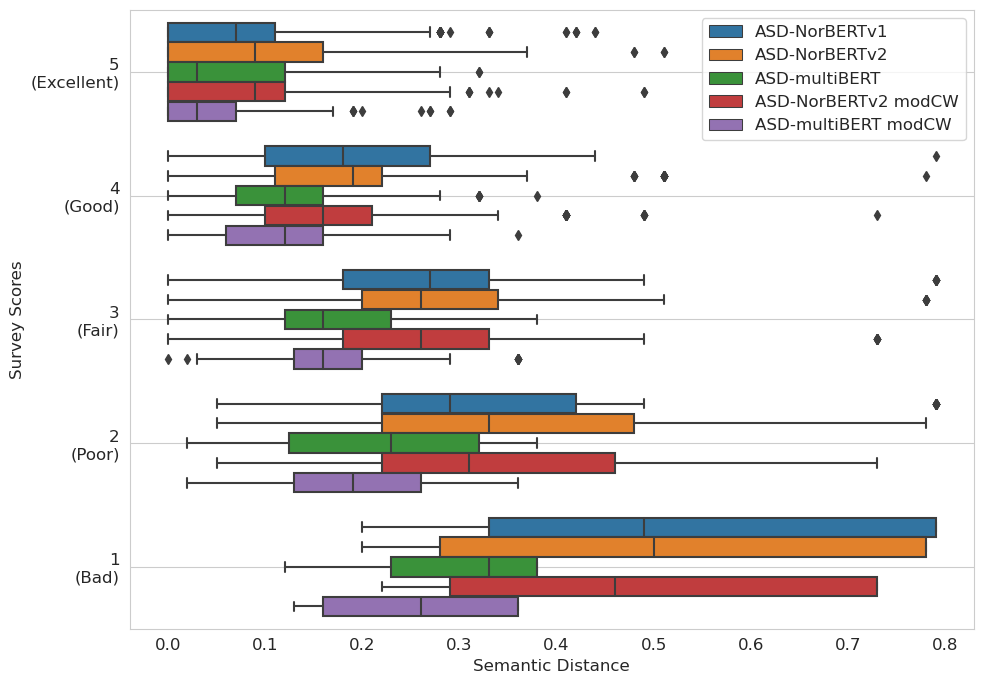

In [17]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
order = reversed(sorted(sem_eval_versusASDversions_forboxplot["user_rating"].unique()))
ylabels = ["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"]
ylabels.reverse()

plt.figure(figsize=(10,7))
sns.boxplot(data=sem_eval_versusASDversions_forboxplot.round(2), x="metric_score", y="user_rating", hue="metric_type", order=order, orient="h", palette="tab10")
plt.xlabel('Semantic Distance')
plt.ylabel('Survey Scores')
plt.yticks(np.arange(5), labels=ylabels)
plt.tight_layout()
plt.grid()
plt.legend(loc="best")
# plt.savefig('./interspeech2023_plots/ASD_ASDmulti_vs_user_ratings.pdf')

### Linear Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
metric_list = ["wer", "matchem_wer", "asd_norbert", "asd_norbert2", "asd_norbert2_cw_mod", "asd_multi", "asd_multi_cw_mod"]

data_train = []
data_test = []

for metric in metric_list:
    X = sem_eval_consolidated[[metric]]
    Y = sem_eval_consolidated.user_rating

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)

    # results on train set
    Y_pred_train = model.predict(X_train)
    data_train.append([metric.upper(), mean_squared_error(Y_train, Y_pred_train),
                 mean_absolute_error(Y_train, Y_pred_train), r2_score(Y_train, Y_pred_train)])

    # results on test set
    Y_pred_test = model.predict(X_test)
    data_test.append([metric.upper(), mean_squared_error(Y_test, Y_pred_test),
                 mean_absolute_error(Y_test, Y_pred_test), r2_score(Y_test, Y_pred_test)])


linreg_test_results = pd.DataFrame(data_test, columns=["metric", "MSE", "MAE", "R2"])
linreg_test_results.sort_values("MSE", axis="index", ascending=True)

,metric,MSE,MAE,R2
4,ASD_NORBERT2_CW_MOD,0.828857,0.715437,0.445349
5,ASD_MULTI,0.835351,0.722712,0.441003
6,ASD_MULTI_CW_MOD,0.840512,0.734446,0.437549
3,ASD_NORBERT2,0.868090,0.741520,0.419095
1,MATCHEM_WER,0.911413,0.757062,0.390104
2,ASD_NORBERT,0.930251,0.773043,0.377499
0,WER,0.976840,0.790943,0.346322


In [ ]:
metric_list = [["wer", "asd_norbert"], ["wer", "asd_norbert2"], ["wer", "asd_norbert2_cw_mod"], ["wer", "asd_multi"], ["wer", "asd_multi_cw_mod"],
              ["matchem_wer", "asd_norbert"], ["matchem_wer", "asd_norbert2"], ["matchem_wer", "asd_norbert2_cw_mod"], ["matchem_wer", "asd_multi"], ["matchem_wer", "asd_multi_cw_mod"]]

data_train = []
data_test = []

for metric in metric_list:
    X = sem_eval_consolidated[metric]
    Y = sem_eval_consolidated.user_rating

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)

    # results on train set
    Y_pred_train = model.predict(X_train)
    data_train.append([(metric[0] + "+" + metric[1]).upper(), mean_squared_error(Y_train, Y_pred_train),
                 mean_absolute_error(Y_train, Y_pred_train), r2_score(Y_train, Y_pred_train)])

    # results on test set
    Y_pred_test = model.predict(X_test)
    data_test.append([(metric[0] + "+" + metric[1]).upper(), mean_squared_error(Y_test, Y_pred_test),
                 mean_absolute_error(Y_test, Y_pred_test), r2_score(Y_test, Y_pred_test)])


linreg_test_results = pd.DataFrame(data_test, columns=["metric", "MSE", "MAE", "R2"])
linreg_test_results.sort_values("MSE", axis="index", ascending=True)

,metric,MSE,MAE,R2
2,WER+ASD_NORBERT2_CW_MOD,0.810027,0.717283,0.457950
7,MATCHEM_WER+ASD_NORBERT2_CW_MOD,0.817982,0.716363,0.452626
3,WER+ASD_MULTI,0.831981,0.720630,0.443258
8,MATCHEM_WER+ASD_MULTI,0.835602,0.721220,0.440835
4,WER+ASD_MULTI_CW_MOD,0.840479,0.733519,0.437571
9,MATCHEM_WER+ASD_MULTI_CW_MOD,0.840796,0.731609,0.437359
1,WER+ASD_NORBERT2,0.865165,0.740146,0.421052
6,MATCHEM_WER+ASD_NORBERT2,0.867300,0.737190,0.419624
5,MATCHEM_WER+ASD_NORBERT,0.902805,0.753748,0.395865
0,WER+ASD_NORBERT,0.927425,0.771194,0.379389


### Bayesian Classifier

STRATIFIED K-FOLD
------
 WER
0.363 accuracy with a standard deviation of 0.035
1.222 MSE with a standard deviation of 0.112


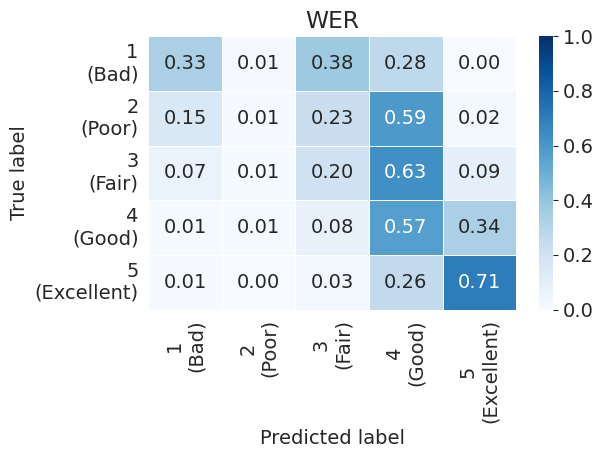

STRATIFIED K-FOLD
------
 MATCHEM_WER
0.361 accuracy with a standard deviation of 0.043
1.208 MSE with a standard deviation of 0.126


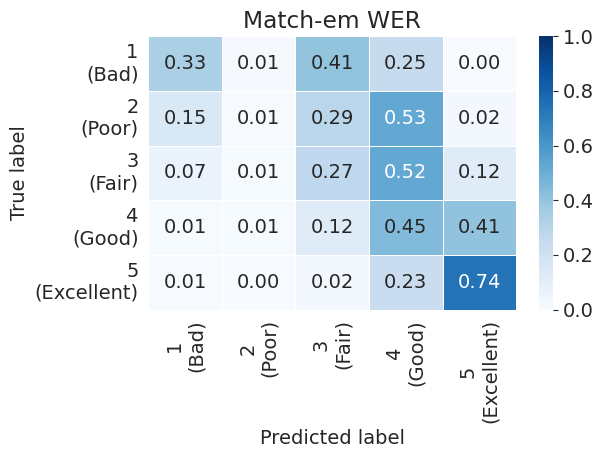

STRATIFIED K-FOLD
------
 ASD_NORBERT
0.390 accuracy with a standard deviation of 0.029
1.018 MSE with a standard deviation of 0.101


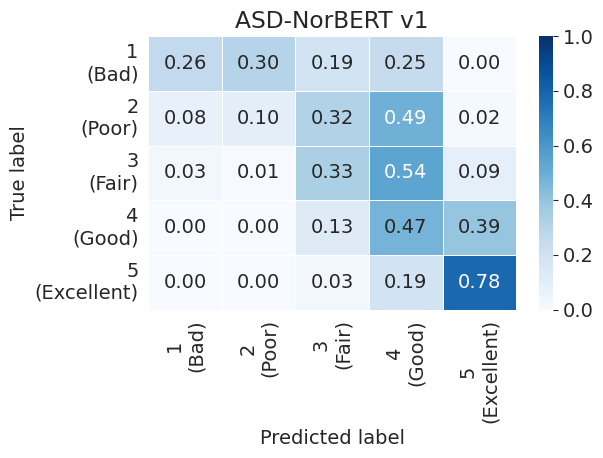

STRATIFIED K-FOLD
------
 ASD_NORBERT2
0.398 accuracy with a standard deviation of 0.027
1.046 MSE with a standard deviation of 0.133


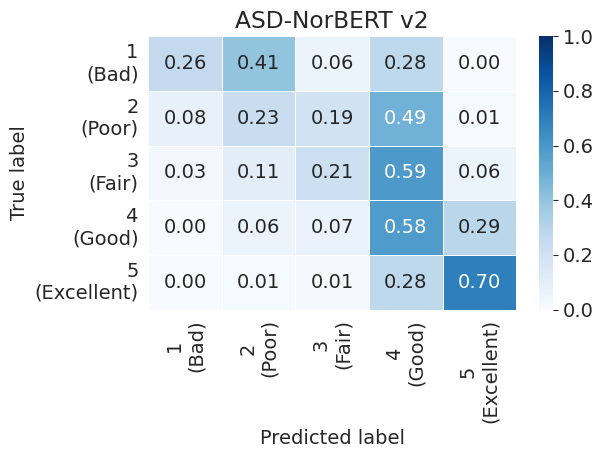

STRATIFIED K-FOLD
------
 ASD_NORBERT2_CW_MOD
0.398 accuracy with a standard deviation of 0.033
1.018 MSE with a standard deviation of 0.123


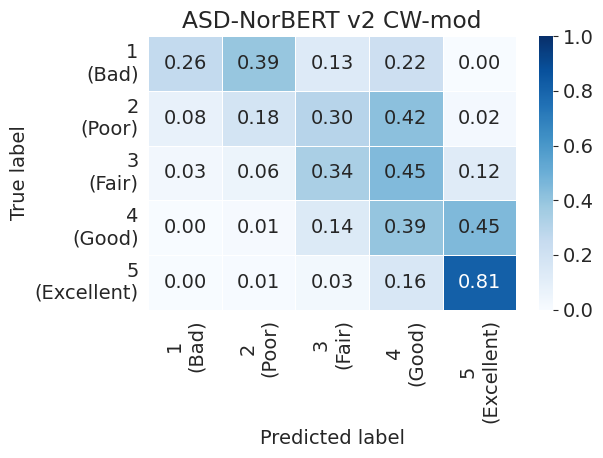

STRATIFIED K-FOLD
------
 ASD_MULTI
0.412 accuracy with a standard deviation of 0.034
0.949 MSE with a standard deviation of 0.123


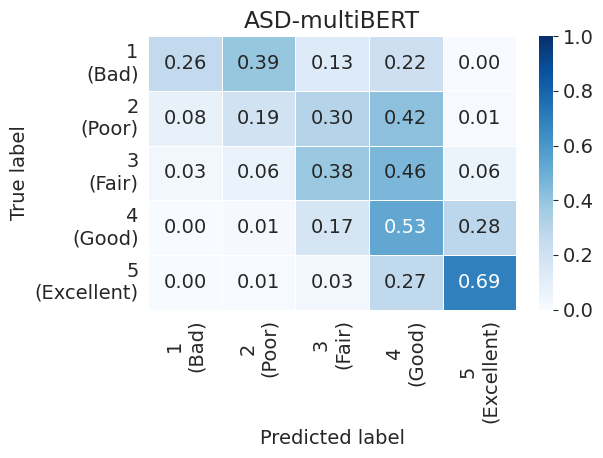

STRATIFIED K-FOLD
------
 ASD_MULTI_CW_MOD
0.376 accuracy with a standard deviation of 0.033
1.145 MSE with a standard deviation of 0.154


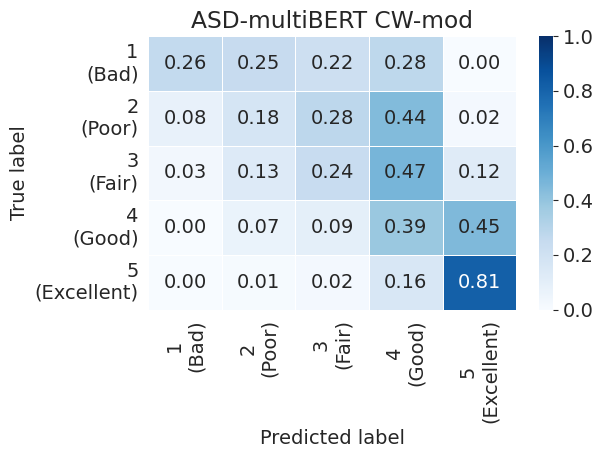

In [ ]:
# 10-FOLD STRATIFIED
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

plt.rcParams.update({'font.size': 14})

metric_list = ["wer", "matchem_wer", "asd_norbert", "asd_norbert2", "asd_norbert2_cw_mod", "asd_multi", "asd_multi_cw_mod"]
gnb = GaussianNB()

for metric in metric_list:

    if metric == "wer":
        plot_title = "WER"
    elif metric == "matchem_wer":
        plot_title = "Match-em WER"
    elif metric == "asd":
        plot_title = "ASD-NorBERT"
    elif metric == "asd_norbert":
        plot_title = "ASD-NorBERT v1"
    elif metric == "asd_norbert2":
        plot_title = "ASD-NorBERT v2"
    elif metric == "asd_multi":
        plot_title = "ASD-multiBERT"
    elif metric == "asd_multi_middle":
        plot_title = "ASD-multiBERT(5-8)"
    elif metric == "asd_norbert2_cw_mod":
        plot_title = "ASD-NorBERT v2 CW-mod"
    elif metric == "asd_multi_cw_mod":
        plot_title = "ASD-multiBERT CW-mod"

    metric_col = sem_eval_consolidated.columns.get_loc(metric)
    X = sem_eval_consolidated.iloc[:,metric_col]
    y = sem_eval_consolidated.user_rating

    accuracy_score = np.zeros(10)
    mse_score = np.zeros(10)
    confusion_matrices = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    i = 0
    for train, test in skf.split(X,y):
        # print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))
        X_train = X[train].to_numpy().reshape(-1, 1)
        X_test = X[test].to_numpy().reshape(-1, 1)
        y_train = y[train].to_numpy()
        y_test = y[test].to_numpy()
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        accuracy_score[i] = metrics.balanced_accuracy_score(y_test, y_pred)
        mse_score[i] = metrics.mean_squared_error(y_test, y_pred)
        confusion_matrices.append(metrics.confusion_matrix(y_test, y_pred))
        i += 1

    print('STRATIFIED K-FOLD\n------\n', metric.upper())
    print(f'{accuracy_score.mean():.3f} accuracy with a standard deviation of {accuracy_score.std():.3f}')
    print(f'{mse_score.mean():.3f} MSE with a standard deviation of {mse_score.std():.3f}')

    cm_mean = np.mean(np.array(confusion_matrices), axis=0)
    cm_mean_normalized = cm_mean / cm_mean.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_mean_normalized, vmin=0, vmax=1, linecolor="white",
                annot=True, fmt=".2f", linewidth=0.5, cmap="Blues",
                xticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"],
                yticklabels=["1\n(Bad)", "2\n(Poor)", "3\n(Fair)", "4\n(Good)", "5\n(Excellent)"])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(plot_title)
    plt.tight_layout()
    # plt.savefig('./interspeech2023_plots/cm_10foldstratified_'+metric+'.pdf')
    plt.show()


## E2E ASR results

In [ ]:
df_file = "./E2E_ASR_results_from_TUL/e2e_segmented/df_e2e_consolidated_clean.csv"
df_e2e = pd.read_csv(df_file)
# df_e2e.drop(labels=["Unnamed: 0", "wer", "asd"], axis="columns", inplace=True)

chars_to_ignore_regex = '[\,\?\.\!\–\;\:\"\*]'
df_e2e["ref_text"] = df_e2e[["ref_text"]].swifter.apply(lambda row: re.sub(r'[^\w]', ' ', row.ref_text), axis=1)
df_e2e["asr_text"] = df_e2e[["asr_text"]].swifter.apply(lambda row: re.sub(r'[^\w]', ' ', row.asr_text), axis=1)

# df_e2e["wer"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: wer(row.ref_text, row.asr_text), axis=1)
# df_e2e["matchem_wer"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: analysis.wer(analysis.compute_mistakes((row.ref_text).lower(), (row.asr_text).lower()))/100, axis=1)

# df_e2e["asd_norbert"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert, asd_tokenizer_norbert), axis=1)
# df_e2e["asd_norbert2"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_model_norbert2, asd_tokenizer_norbert2), axis=1)

# df_e2e["asd_multi"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)

df_e2e["asd_norbert2_cw_mod"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_cw_mod(row.ref_text, row.asr_text, asd_model_norbert2, asd_tokenizer_norbert2), axis=1)
# df_e2e["asd_multi_cw_mod"] = df_e2e[["ref_text", "asr_text"]].swifter.apply(lambda row: get_asd_score_cw_mod(row.ref_text, row.asr_text, asd_multi_model, asd_multi_tokenizer), axis=1)


Pandas Apply:   0%|          | 0/6971 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6971 [00:00<?, ?it/s]

In [ ]:
df_e2e